In [ ]:
%load_ext rpy2.ipython 

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Load information

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Auth done!


Write all posts utf-8 version
Write view party csv
Write view election csv
Write FB users csv
Write country polarization csv
Write gdp per capita csv
Write population csv
Write FB followers csv


# Libraries

In [ ]:
%%capture
%%R

install.packages("data.table")

library(data.table)
library(tidyverse)
library(scales)


In [ ]:
%%capture
%%R
install.packages("corrplot") 
library(corrplot)
install.packages("Hmisc")
library("Hmisc")

In [ ]:
%%capture
%%R
install.packages("caret")
library(caret)
install.packages("glmnet")
library(glmnet)

In [ ]:
%%capture
%%R
install.packages("regclass")
library(regclass)

# Load posts file


In [ ]:
%%R
posts_data <- data.table()
posts_file <- "all_posts.csv"
last_file <- ""
load_initial_data <- function(initial_date,final_date, country_to_filter){
  if((dim(posts_data)[1] == 0) | last_file != posts_file){
      
  view_party <- read.csv("view_party.csv", encoding="UTF8")

  view_party_data <- view_party %>% filter(!is.na(facebook_id))
  all_posts_collected_utf.8 <<- read.csv(posts_file, encoding="UTF8")
  if(!missing(country_to_filter)){
      view_party_data <- view_party_data %>% filter(country_name==country_to_filter)
  }

  view_party_data <<- view_party_data
  posts_data <<- all_posts_collected_utf.8 %>% filter(page_id %in% c(view_party_data$facebook_id))


  for(id in view_party_data$facebook_id){
    if(!is.na(view_party_data$left_right[view_party_data$facebook_id==id])){
      posts_data$ideology[posts_data$page_id==id] <- switch(round(view_party_data$left_right[view_party_data$facebook_id==id])+1, "far-left", "far-left", "left", "left", "center", "center", "center", "right", "right", "far-right", "far-right")
    }else{
      posts_data$ideology[posts_data$page_id==id] <- NA
    }
    posts_data$left_right[posts_data$page_id==id] <- view_party_data$left_right[view_party_data$facebook_id==id]
    posts_data$country_name[posts_data$page_id==id] <- view_party_data$country_name[view_party_data$facebook_id==id]
    posts_data$family_name[posts_data$page_id==id] <- view_party_data$family_name[view_party_data$facebook_id==id]
    posts_data$party_name[posts_data$page_id==id] <- view_party_data$party_name[view_party_data$facebook_id==id]
    posts_data$party_name_short[posts_data$page_id==id] <- view_party_data$party_name_short[view_party_data$facebook_id==id]
    posts_data$party_id[posts_data$page_id==id] <- view_party_data$party_id[view_party_data$facebook_id==id]

    #posts_data$page_id[posts_data$page_id==id] <- paste(view_party_data$country_name_short[view_party_data$facebook_id==id], view_party_data$party_name_short[view_party_data$facebook_id==id], sep = ": ") 

  }

  dates <- strsplit(as.character(posts_data$timestamp), split=" ")
  sep<- sapply(dates, "[", 1)

  month <- format(as.Date(sep, format="%Y-%m-%d"), format = "%Y/%m")
  week <- format(as.Date(sep, format="%Y-%m-%d"), format = "%Y/%U")
  for(w in seq(week)){
	  p <- str_split(week[w], "/")
		if(p[[1]][2] == "00"){
			week[w] = paste(strtoi(p[[1]][1])-1, 52, sep="/")
		}
	}
  last_file <<- posts_file
  week <- as.Date(paste(week, "1", sep = "/"), format = "%Y/%U/%w")


  posts_data <- posts_data %>% add_column(month, .before = "comments")
  posts_data <- posts_data %>% add_column(week, .before = "month")

  posts_data$week[posts_data$month=="2019/01" & is.na(posts_data$week)] <<- as.Date("2018-12-31", format="%Y-%m-%d")
  posts_data$week[posts_data$month=="2020/01" & is.na(posts_data$week)] <<- as.Date("2019-12-30", format="%Y-%m-%d")

  #posts_data <- posts_data %>% union( posts_data %>% filter(party_name=="Sinn Féin") %>% mutate(ideology="far-left", left_right=1.3, country_name = "United Kingdom")   )

  posts_data <<- posts_data

  #TODO: Remove filters)
  }
  posts_data_act <- data.table(posts_data)

  if(!missing(country_to_filter)){
      posts_data_act <- posts_data_act %>% filter(country_name==country_to_filter)
  }
  print(paste("Total posts wihtout filters:", length(posts_data_act$comments)))
  posts_data_act <- posts_data_act  %>% filter(as.Date(timestamp) < as.Date(final_date)) %>% filter(as.Date(timestamp) > as.Date(initial_date))
  print(paste("Total posts with date filters:", length(posts_data_act$comments)))

  posts_data <<- posts_data
  posts_data_act <<- posts_data_act
  countries <<- unique(posts_data$country_name)
}

load_initial_data("2018-12-31", "2022-01-01")

[1] "Total posts wihtout filters: 627919"
[1] "Total posts with date filters: 561295"


In [ ]:
%%R 
cn = unique(posts_data$country_name)
eu_ideologies = data.table("country_name" = cn, "max" = 0.0, "min" = 0.0, "center" = 0.0)

for(c in cn){
    ideologies <- unique((posts_data
 %>% filter(country_name==c) %>% filter(!is.na(left_right)) )$left_right) 
    
    for(i in ideologies){

        if(eu_ideologies[country_name==c]$max < i){
            eu_ideologies[country_name==c]$max <- i
        }
        if(eu_ideologies[country_name==c]$min == 0 ||eu_ideologies[country_name==c]$min > i){
            eu_ideologies[country_name==c]$min <- i
        }
    }

    eu_ideologies[country_name==c]$center <- eu_ideologies[country_name==c]$min + (eu_ideologies[country_name==c]$max - eu_ideologies[country_name==c]$min)/2 
}
eu_ideologies <- eu_ideologies[order(eu_ideologies$min),]
print(eu_ideologies[order(eu_ideologies$min),])

      country_name    max    min  center
 1:     Luxembourg 8.8158 0.5263 4.67105
 2: Czech Republic 8.8000 0.7498 4.77490
 3:        Denmark 8.2269 0.8912 4.55905
 4:         Cyprus 8.8000 1.0526 4.92630
 5:        Germany 8.8000 1.2152 5.00760
 6:       Slovenia 7.9345 1.3000 4.61725
 7:        Belgium 9.6622 1.3000 5.48110
 8:          Spain 8.8000 1.3000 5.05000
 9:         France 9.6854 1.3000 5.49270
10:          Italy 7.8007 1.3000 4.55035
11:        Ireland 7.4000 1.3000 4.35000
12:         Greece 8.8000 1.3000 5.05000
13:    Netherlands 8.8000 1.3682 5.08410
14:         Sweden 8.8000 1.5464 5.17320
15:       Portugal 8.0222 1.6425 4.83235
16:        Croatia 8.8000 1.8421 5.32105
17:         Latvia 8.8000 1.8640 5.33200
18:        Finland 8.8000 2.1843 5.49215
19:        Austria 8.3494 2.4604 5.40490
20:      Lithuania 8.8000 2.5000 5.65000
21:        Estonia 8.4962 2.5000 5.49810
22: United Kingdom 8.8000 2.5700 5.68500
23:         Poland 8.8000 2.8299 5.81495
24:        Hunga

[1] 8.8
[1] 7.4
[1] 6
[1] 7.4
[1] 8.8
[1] 6
[1] 6.021
[1] 6
[1] 7.4
[1] 7.4
[1] 7.421
[1] 8.8
[1] 6
[1] 6
[1] 6.021
[1] 3.3
[1] 3.3
[1] 3.321
[1] 8.8
[1] 6
[1] 1.3
[1] 7.4


R[write to console]: Saving 16.7 x 14.6 in image



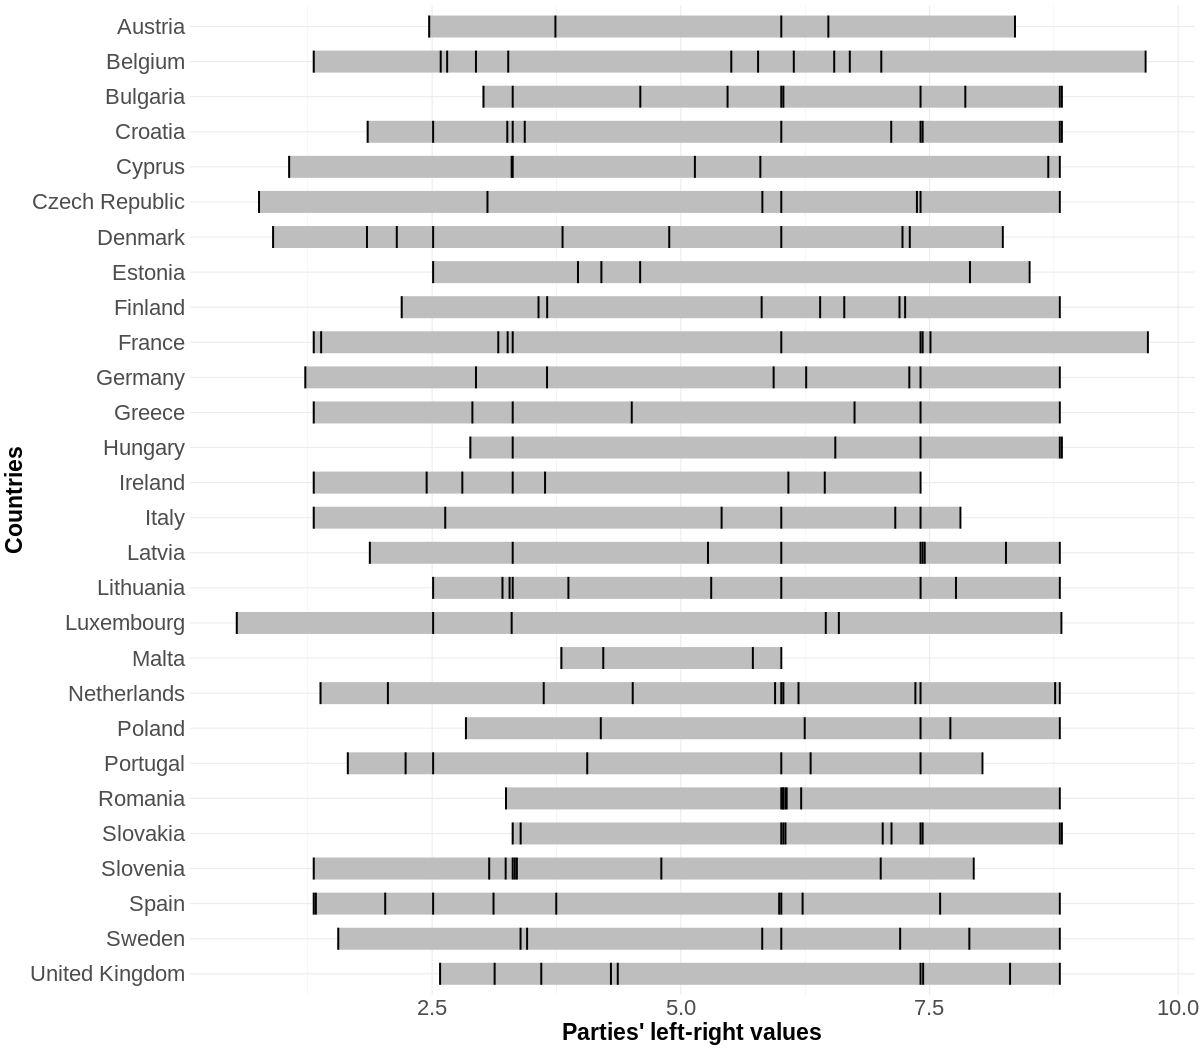

In [ ]:
%%R -w 1200 -h 1050 -u px
eu_ideologies <- eu_ideologies[order(eu_ideologies$country_name),]
eu_ideologies_to_plot <- data.table(eu_ideologies, alpha_order=c(1:28) * - 1) # this is to order alphab

myplot <- ggplot(data = eu_ideologies_to_plot)+
  geom_segment(aes(x = reorder(country_name,(alpha_order)), xend = country_name, y = min, yend = max), size = 10.3, colour = "gray", alpha = 1) + #  colour = "darkcyan", alpha = 0.7) the second variable of reorder is the variable to sort
  coord_flip() +
  xlab("Countries") +
  theme_minimal() +
  theme(axis.text=element_text(size=22),
        axis.title=element_text(size=23,face="bold"), legend.text=element_text(size=14), legend.title=element_text(size=15)) +
  ylab("Parties' left-right values")#ylab("Valores left-right de los partidos políticos")


index <- 1
country_index <- 1

for(c in cn){
    ideologies <- posts_data %>% filter(country_name==c) %>% filter(!is.na(left_right)) %>% group_by(page_id, left_right) %>% summarise(n=1,  .groups = 'drop')
    ideology_index <- 1 
    array <- c()

    for(i in ideologies$left_right){
        while(as.numeric(i) %in% array){
          print(i)
          i <- as.numeric(i) + 0.021 

        }
        array <- c(array, as.numeric(i))

        gg.data <- data.frame(country = c, ystart = i, ylast = i + 0.02)
        myplot <- myplot + geom_segment(data=gg.data, aes(x = country, xend=country, y = ystart, yend = ylast), size = 10.3, colour = "black")  #+ geom_segment(aes(x = c, xend=c, y = i-1, yend = i + 0.01), size = 5, colour = "black") 

    }
    country_index <- country_index + 1

}


ggsave("Figure2.pdf", myplot)
print(myplot)

In [ ]:
%%R
FB_users <- read.csv("FB_users.csv", encoding="UTF8")

FB_users  <- FB_users %>% filter(country %in% cn) %>% select(country,mau_FB) %>% rename(country_name=country)

In [ ]:
%%R
summary <- posts_data %>% inner_join(FB_users, by="country_name") %>% group_by(party_name, country_name, left_right) %>% summarise(posts=length(comments), reac=median(reaction_count), comm=median(comments))
summary <- summary %>% inner_join(posts_data %>% filter(!is.na(video_views)) %>% filter(video_views!="NaN") %>% group_by(party_name) %>% summarise(views=median(video_views)), by="party_name")


`summarise()` has grouped output by 'party_name', 'country_name'. You can
override using the `.groups` argument.


In [ ]:
%%R
total_days = 1000
fill_array <- function(array){
    i <- length(array)
    if(i < total_days){
        for(index in 1:total_days){
            if(is.na(array[index])){
                array[index] <- 0
            }
        }
    }
    return(array)
    
}

In [ ]:
%%R 
calculate_ideology <- function(values){
    
  index <- 1

  for(ideo in values){
      if (ideo > 8.5){
        values[index] <- "far-right"
      }else if(ideo >= 6.5){
        values[index] <- "right"
      }else if(ideo > 5){
          values[index] <- "centre-right"
      }else if(ideo > 3.5){
        values[index] <- "centre-left"
      }else if(ideo >= 1.5){
        values[index] <- "left"
      }else{
        values[index] <- "far-left"
      }

      index <- index + 1
  }

  return(factor(values, levels=c("far-left","left","centre-left","centre-right","right","far-right")))
}
print(calculate_ideology(c(1,6,8,9,4)))

posts_data_act_c <- posts_data_act %>% filter(!is.na(left_right)) %>% arrange(left_right) %>% mutate(ideology = calculate_ideology(left_right))
print(length(unique(posts_data_act_c$page_id)))

FB_users <- read.csv("FB_users.csv", encoding="UTF8")

FB_users  <- FB_users %>% filter(country %in% cn) %>% select(country,mau_FB) %>% rename(country_name=country)
#posts_data_act_c <- posts_data_act_c %>% mutate(mau_FB = get_fb_users_country(country_name)) ## Hacer esto con un join o algo porque esto así consume muchos recursos
posts_data_act_c <- posts_data_act_c %>% inner_join(FB_users, by="country_name")
posts_data_act_c <- posts_data_act_c %>% mutate(day=as.Date(unlist(lapply(str_split(timestamp, " "), `[[`, 1))))

print(posts_data_act_c %>% group_by(ideology) %>% summarise(count = length(party_id)))
print(length(unique(posts_data_act_c$page_id)))

[1] far-left     centre-right right        far-right    centre-left 
Levels: far-left left centre-left centre-right right far-right
[1] 234
# A tibble: 6 × 2
  ideology      count
  <fct>         <int>
1 far-left      32975
2 left         127533
3 centre-left   47320
4 centre-right 108228
5 right        155814
6 far-right     58572
[1] 234


`summarise()` has grouped output by 'ideology'. You can override using the
`.groups` argument.


R[write to console]: Saving 13.9 x 10.4 in image



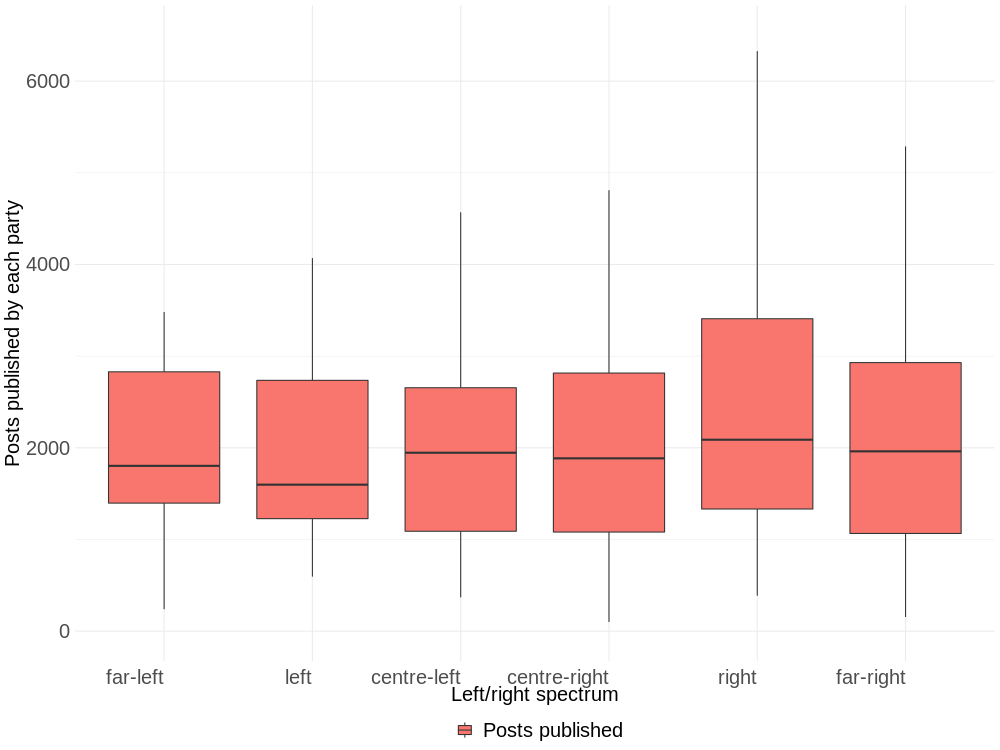

In [ ]:
%%R -w 1000 -h 750 -u px
reaction_posts <- posts_data_act_c %>% filter(!is.na(left_right)) %>% filter(timestamp < as.Date("2022-01-01")) %>% group_by(ideology,party_id) %>% summarise(posts=length(post_id), reactions=median(reaction_count), variable=0, variable_name="")
reaction_posts <- reaction_posts %>% bind_rows(reaction_posts)

rows <- dim(reaction_posts)[1]

scale_value = 4
for(t in seq(rows)){
  if(t <= rows/2){
    reaction_posts$variable[t] <- reaction_posts$posts[t]
    reaction_posts$variable_name[t] <- "Posts published"  
  }else{
    reaction_posts$variable[t] <- reaction_posts$reactions[t] * scale_value
    reaction_posts$variable_name[t] <- "Reactions received"  
  }
}
figure4 <- ggplot(reaction_posts %>% filter(variable_name=="Posts published")) +
  aes(x = ideology, y = variable, fill=variable_name, na.rm=TRUE) +
  geom_boxplot(outlier.shape = NA) +
  coord_cartesian(ylim = c(0,6500)) +
  scale_fill_discrete(name = "") +
  scale_y_continuous(
    # Features of the first axis
    name = "Posts published by each party",
  ) +
  labs(x = "Left/right spectrum") +
  theme_minimal() + theme(legend.position="bottom", axis.text.x = element_text(vjust = 0, hjust=1, size=20), axis.text.y = element_text(size=20), strip.text.x = element_text(size = 20),
                            axis.title.y = element_text(size=20), axis.title.x = element_text(size=20), legend.text=element_text(size=20), legend.title=element_text(size=20))
  
print(figure4)
ggsave("Figure4.pdf", figure4)

In [ ]:
%%R 

cn = eu_ideologies$country_name
print(cn)
total <- 0
posts_data_c <- posts_data %>% filter(!is.na(left_right))
for(c in cn){
    print(c)
    total <- total + length(unique( (posts_data_c %>% filter(country_name==c))$page_id))
    print(length(unique( (posts_data_c %>% filter(country_name==c))$page_id)))
     print(length( (posts_data_c %>% filter(country_name==c))$page_id))
}
print(paste("Total:", total, sep=" "))

 [1] "Austria"        "Belgium"        "Bulgaria"       "Croatia"       
 [5] "Cyprus"         "Czech Republic" "Denmark"        "Estonia"       
 [9] "Finland"        "France"         "Germany"        "Greece"        
[13] "Hungary"        "Ireland"        "Italy"          "Latvia"        
[17] "Lithuania"      "Luxembourg"     "Malta"          "Netherlands"   
[21] "Poland"         "Portugal"       "Romania"        "Slovakia"      
[25] "Slovenia"       "Spain"          "Sweden"         "United Kingdom"
[1] "Austria"
[1] 5
[1] 16082
[1] "Belgium"
[1] 12
[1] 23840
[1] "Bulgaria"
[1] 10
[1] 27113
[1] "Croatia"
[1] 11
[1] 20219
[1] "Cyprus"
[1] 7
[1] 22877
[1] "Czech Republic"
[1] 7
[1] 22457
[1] "Denmark"
[1] 10
[1] 13100
[1] "Estonia"
[1] 6
[1] 14665
[1] "Finland"
[1] 9
[1] 20098
[1] "France"
[1] 10
[1] 25451
[1] "Germany"
[1] 8
[1] 18663
[1] "Greece"
[1] 7
[1] 21983
[1] "Hungary"
[1] 6
[1] 31065
[1] "Ireland"
[1] 8
[1] 12663
[1] "Italy"
[1] 7
[1] 47468
[1] "Latvia"
[1] 9
[1] 14963
[1

In [ ]:
%%R 
CountryPPD <- posts_data_act_c %>% filter(!is.na(left_right)) %>% group_by(country_name, day) %>% summarise(total_posts=length(page_id)) %>% group_by(country_name) %>% summarise(CountryPPD = round(mean(fill_array(total_posts)),3), CountrySD = round(sd(fill_array(total_posts)),3) )

In [ ]:
%%R 
PartyPPD <- posts_data_act_c  %>% filter(!is.na(left_right)) %>% group_by(country_name, party_id,day) %>% summarise(total_posts=length(page_id)) %>% group_by(country_name, party_id) %>% summarise(posts_per_day=mean(total_posts)) %>% group_by(country_name) %>% summarise(PartyPPD = round(mean(posts_per_day),3), PartySD = round(sd(posts_per_day), 3))

In [ ]:
%R posts_data_act_c %>% filter(!is.na(left_right)) %>% filter(as.Date(timestamp) < as.Date("2022-01-01")) %>% group_by(country_name) %>% summarise(parties = length(unique(party_id)), posts=length(post_id)) %>% left_join(CountryPPD, by="country_name")%>% left_join(PartyPPD, by="country_name") %>% filter(country_name %in% c("Germany", "Croatia", "Bulgaria", "Lithuania"))

country_name  parties  posts  CountryPPD  CountrySD  PartyPPD  PartySD
1     Bulgaria       10  24261      22.156     12.533     3.315    1.116
2      Croatia       11  18781      17.183     11.494     2.515    0.748
3      Germany        8  16883      15.404      7.085     2.290    0.709
4    Lithuania       10   9518       9.359      6.162     1.992    0.435

In [ ]:
%%R 
gdp <- read.csv("gdp_per_capita.csv", encoding="UTF8") %>% select(country_name, X2019) %>% rename(gdp=X2019)
population <- read.csv("eu_population.csv", encoding="UTF8") %>% select(country_name, X2019) %>% rename(population=X2019)

In [ ]:
%%R 
join_table <- posts_data_act_c %>% filter(!is.na(left_right)) %>%
 filter(as.Date(timestamp) < as.Date("2022-01-01")) %>%
  group_by(country_name) %>% summarise(parties = length(unique(party_id)), posts=length(post_id)) %>%
   left_join(CountryPPD, by="country_name") %>% left_join(PartyPPD, by="country_name") %>%
   left_join(gdp, by="country_name") %>% left_join(population, by="country_name")

In [ ]:
%%R

print(cor(join_table$CountryPPD,join_table$gdp))
print(cor(join_table$CountryPPD,join_table$population))
print(cor(join_table$gdp,join_table$population))

[1] -0.3953742
[1] 0.447043
[1] 0.03467834


R[write to console]: Saving 20.8 x 8.33 in image



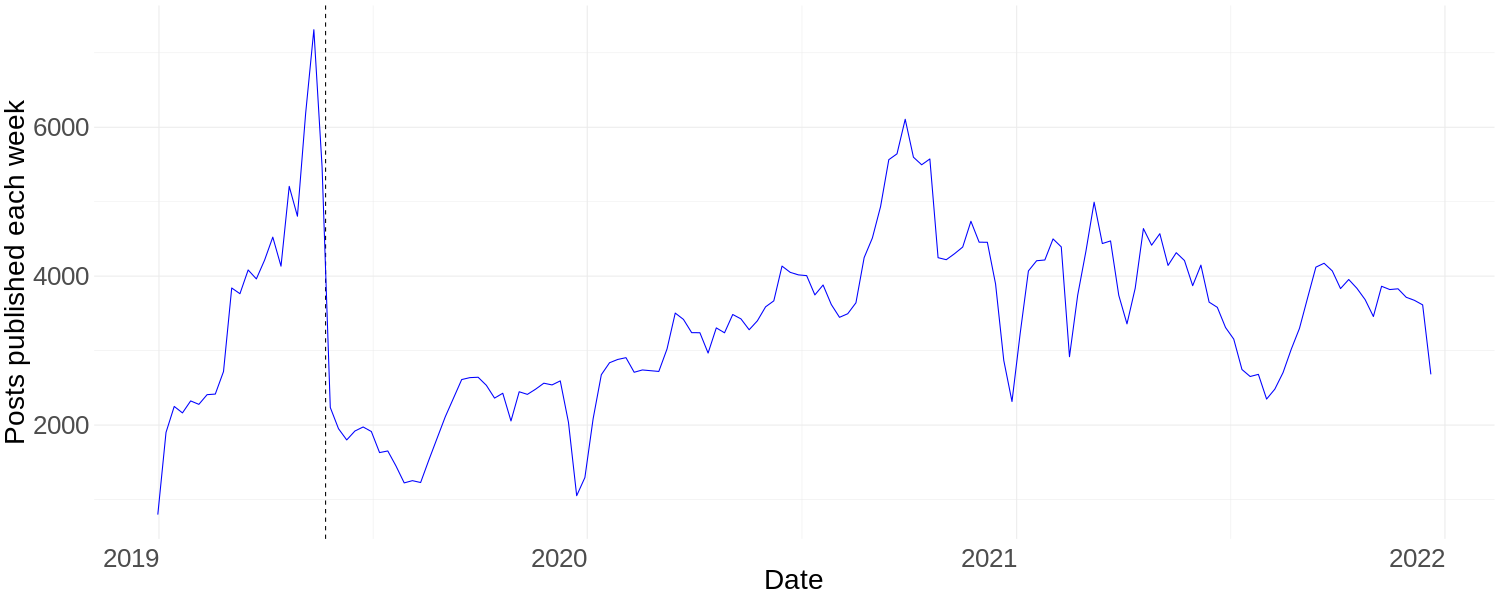

In [ ]:
%%R -w 1500 -h 600 -u px

post_activity <- ggplot(posts_data %>% filter(!is.na(left_right)) %>% filter(timestamp < as.Date("2022-01-01")) %>% group_by(week) %>% summarise(posts=length(week)) %>% slice(-n())) +
    aes(x = week, na.rm=TRUE) +
    xlab("Date") +
    ylab("Posts published each week") +
     geom_vline(data = data.frame(xint=as.Date("2019-05-23")), aes(xintercept = xint), linetype="dashed") +
    geom_line(aes(y=posts), outlier.shape = NA, color="blue") +
    theme_minimal() + theme(axis.text.x = element_text(vjust = 0, hjust=1, size=26), axis.text.y = element_text(size=26),
                            axis.title.y = element_text(size=28), axis.title.x = element_text(size=28), legend.text=element_text(size=26), legend.title=element_text(size=26))

ggsave("Figure3.pdf", post_activity)
print(post_activity)

In [ ]:
%R reaction_posts %>% group_by(ideology) %>% summarise(m = median(posts))

ideology       m
1      far-left  1803.0
2          left  1598.0
3   centre-left  1946.0
4  centre-right  1885.0
5         right  2088.0
6     far-right  1961.5

In [ ]:
%%R
view_party <- read.csv("view_party.csv", encoding="UTF8")
view_party <- view_party %>% filter(country_name %in% cn)
print(length(unique(view_party$party_id)))

[1] 1294


`summarise()` has grouped output by 'country_name'. You can override using the
`.groups` argument.


R[write to console]: Saving 18.1 x 25 in image



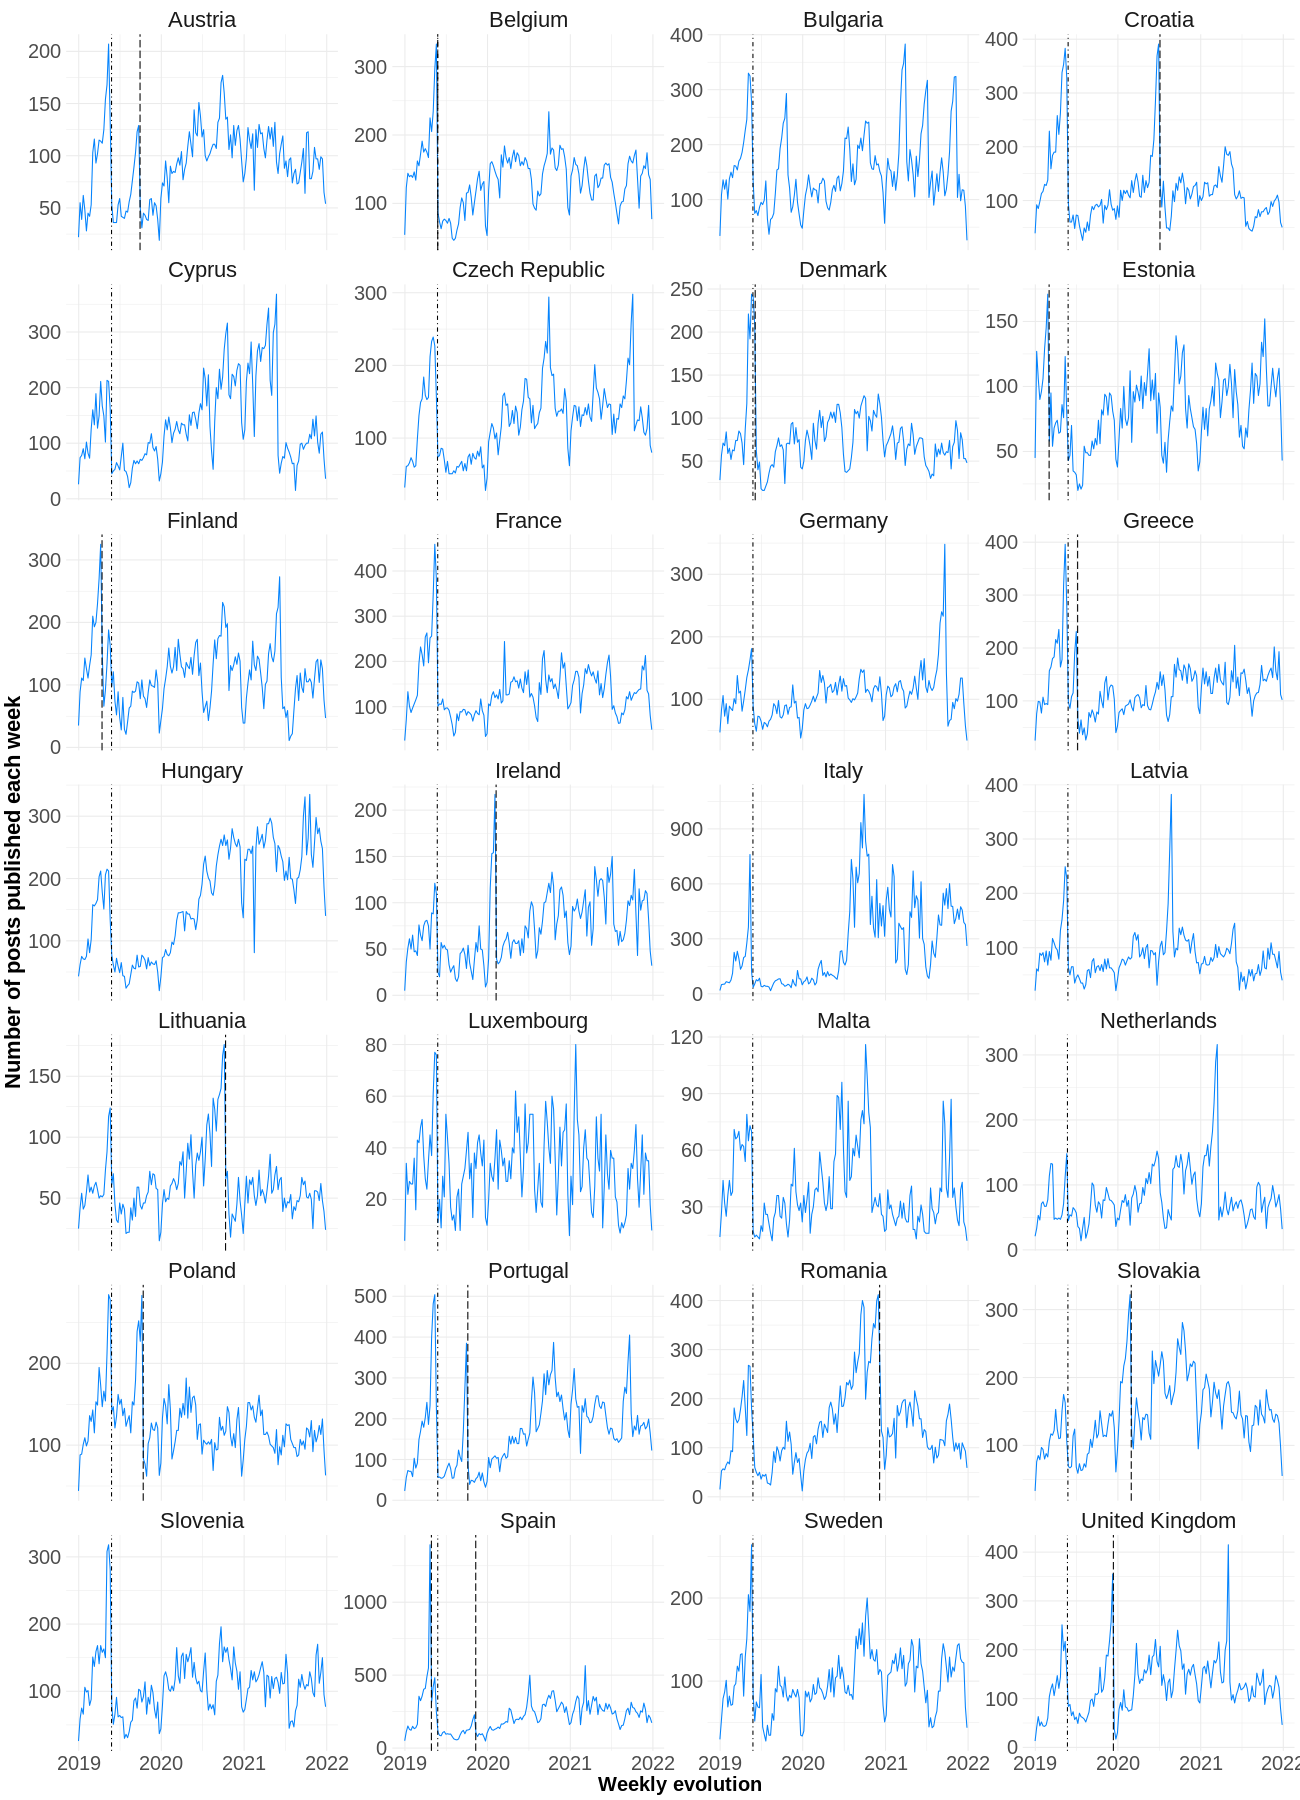

In [ ]:
%%R -w 1300 -h 1800 -u px
view_election <- read.csv("view_election.csv")
view_election <- view_election %>% filter(country_name %in% unique(posts_data_act_c$country_name)) #%>% filter(country_name %in% c("United Kingdom", "Slovakia", "Spain","Ireland","Lithuania", "Austria", "Finland", "Estonia","Belgium", "Poland","Croatia","Denmark"))

view_election <- view_election %>% filter(election_date > as.Date("2019-1-1"))
view_election <- data.table(view_election)
view_election = view_election[,list(data=election_date), by="election_date,country_name,election_type"] 

with_elections <- ggplot(posts_data_act_c %>% group_by(country_name, week) %>% summarise(posts=length(week))) + # %>% filter(time_dif!=Inf)#%>% filter(country_name %in% c("United Kingdom", "Slovakia", "Spain","Ireland","Lithuania", "Austria", "Finland", "Estonia","Belgium", "Poland","Croatia","Denmark")) +
  aes(x = week, y = posts) +
  geom_line(color="#0483fd") +
  labs(x="Weekly evolution", y = "Number of posts published each week") +
  theme_minimal() +
  theme(axis.text=element_text(size=28),
        axis.title=element_text(size=30,face="bold"), legend.text=element_text(size=14), legend.title=element_text(size=15),axis.text.x = element_text(size=20), axis.text.y = element_text(size=20),
                            axis.title.y = element_text(size=22), axis.title.x = element_text(size=20), strip.text.x = element_text(size=22)) +
  facet_wrap(vars(country_name),scales = "free_y",ncol = 4)


for(x in seq(view_election$election_date)){
  country <- view_election[x]$country_name
  date <- as.Date(view_election[x]$election_date)
  if(view_election[x]$election_type=="parliament"){
    with_elections <- with_elections + geom_vline(data = data.frame(xint=date,country_name=country), aes(xintercept = xint), linetype = "longdash")
  }else{
    with_elections <- with_elections + geom_vline(data = data.frame(xint=date,country_name=country), aes(xintercept = xint), linetype = "dotdash")
  }
  
}
print(with_elections)
ggsave("Figure14.pdf", with_elections)

`summarise()` has grouped output by 'week', 'ideology'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'week'. You can override using the
`.groups` argument.


R[write to console]: Saving 16.7 x 11.8 in image



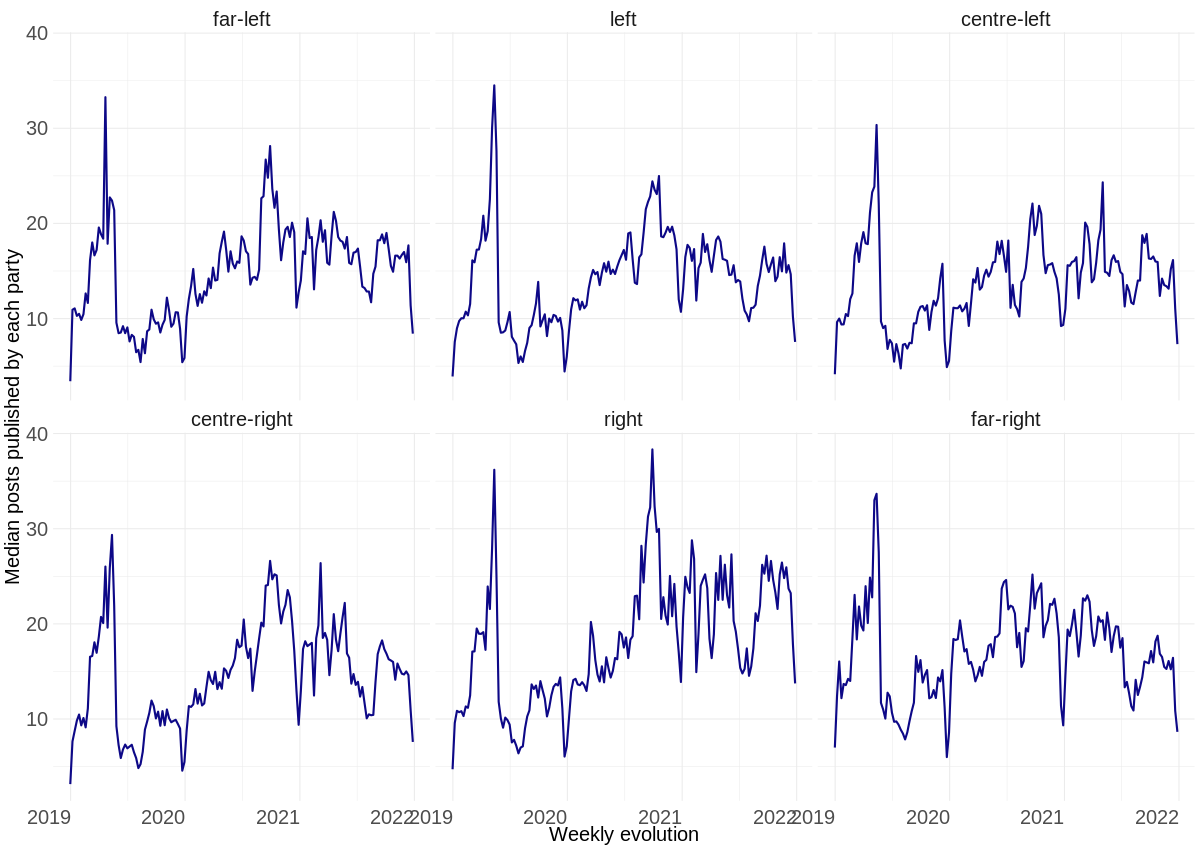

In [ ]:
%%R -w 1200 -h 850 -u px
figure15 <- ggplot(posts_data_act_c %>% group_by(week, ideology,party_id) %>% summarise(posts=length(party_id)) %>% group_by(week,ideology) %>% summarise(posts=mean(posts))) +
  aes(x = week, y = posts) +
  geom_line(size = 1L, colour = "#0d0887") +
  labs(x="Weekly evolution", y = "Median posts published by each party") +
  theme_minimal() +
  facet_wrap(vars(ideology)) + theme(axis.text.x = element_text(vjust = 0, hjust=1, size=20), axis.text.y = element_text(size=20), strip.text.x = element_text(size = 20),
                            axis.title.y = element_text(size=20), axis.title.x = element_text(size=20), legend.text=element_text(size=20), legend.title=element_text(size=20))

print(figure15)
ggsave("Figure15.pdf", figure15)

`summarise()` has grouped output by 'week', 'ideology'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'week'. You can override using the
`.groups` argument.


R[write to console]: Saving 16.7 x 11.8 in image



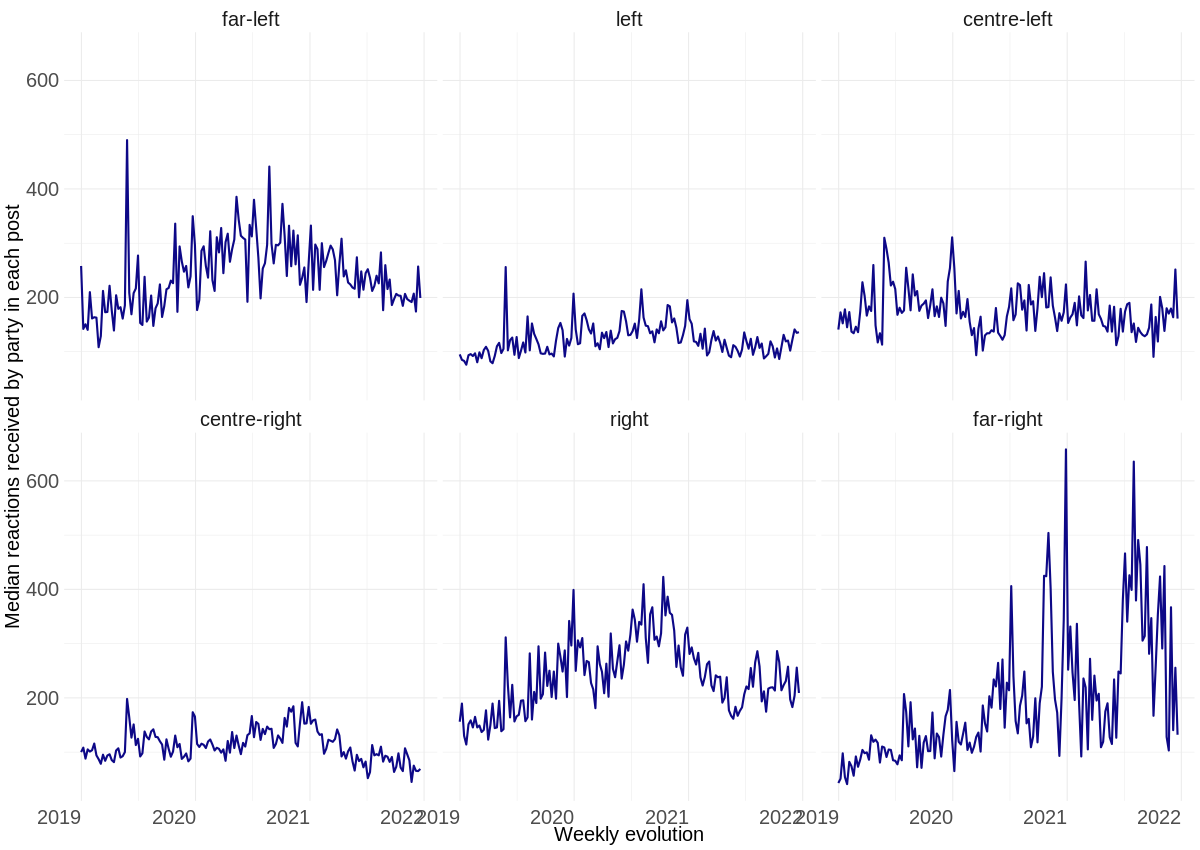

In [ ]:
%%R -w 1200 -h 850 -u px
figure16 <- ggplot(posts_data_act_c %>% filter(timestamp < as.Date("2022-01-01")) %>% filter(week!=max(week)) %>% group_by(week, ideology, party_id) %>% summarise(reaction_count=median(reaction_count)) %>% group_by(week, ideology) %>% summarise(reaction_count=median(reaction_count))) +
  aes(x = week, y = reaction_count) +
  geom_line(size = 1L, colour = "#0d0887") +
  labs(x="Weekly evolution", y = "Median reactions received by party in each post") +
  theme_minimal() +
  facet_wrap(vars(ideology)) + theme(axis.text.x = element_text(vjust = 0, hjust=1, size=20), axis.text.y = element_text(size=20), strip.text.x = element_text(size = 20),
                            axis.title.y = element_text(size=20), axis.title.x = element_text(size=20), legend.text=element_text(size=20), legend.title=element_text(size=20))
  
print(figure16)
ggsave("Figure16.pdf", figure16)

In [ ]:
%%R -w 1300 -h 1800 -u px
view_election <- read.csv("view_election.csv", encoding="UTF8")
data_to_plot <- data.table("country"=NA,"election"=NA, "dalton"=NA, "ideo"=NA)

for(country in cn){
    country_elections <- view_election %>% filter(country_name==country) %>% filter(election_date > as.Date("1960-01-01")) %>% filter(!is.na(left_right)) %>% filter(!is.na(vote_share))  %>% filter(election_type!="ep")
    country_elections_dates <- unique(country_elections$election_date)

    data_to_plot_country <- data.table("country"=country,"election"=country_elections_dates, "dalton"=0.0, "ideo"=0.0)
    for(elec in country_elections_dates){
        current_election <- country_elections %>% filter(election_date == elec) 
        tab <- data.table("variable"=current_election$vote_share, "ideology"=current_election$left_right)
        data_to_plot_country[election==elec]$dalton <- calculate_dalton(tab)
        data_to_plot_country[election==elec]$ideo <- ideology_percentage(current_election, 100)

    }
    data_to_plot <- data_to_plot %>% union(data_to_plot_country)
}
data_to_plot <- data_to_plot %>% filter(!is.na(country))
data_to_plot2 <- data_to_plot %>% mutate(value = ideo, metric="Idelogy")

data_to_plot2 <- data_to_plot2 %>% bind_rows(data_to_plot %>% mutate(value = dalton, metric="Polarization"))
figure17 <- ggplot(data_to_plot2,aes(x = str_split(election,"-",Inf,T)[,1] ,y=value,group=metric,color=metric)) +
    geom_point() +
    geom_line() +
    facet_wrap(vars(country), scales = "free", switch = 'x', ncol=4) +
    labs(x = "Election year", y = "Ideology / Polarization", color="") +
    #scale_colour_manual(values=c("green","red","blue", "purple", "orange")) +
    theme_minimal() + theme(axis.text.x = element_text(size= 18, angle = 90, vjust = 0, hjust=1),
        axis.title=element_text(size=30,face="bold"), legend.text=element_text(size=20), legend.title=element_text(size=15), axis.text.y = element_text(size=20),
                            axis.title.y = element_text(size=22), axis.title.x = element_text(size=20), strip.text.x = element_text(size=22), legend.position = "bottom")
  print(figure17) 
ggsave("Figure17.pdf", figure17)

# Countries ideology

## Ideology by parliament elections 

### By vote share in 2019 european elections (Ground Truth)

In [ ]:
%%R 
# United Kingdom
countries <- unique(posts_data$country_name)

getLastEuropeanElection <- function(country){
    

    view_election <- read.csv("view_election.csv", encoding="UTF8")
    elections_country <- view_election %>% filter(country_name==country) %>% filter(election_type=="ep")

    elections_country <- elections_country %>% filter(as.character(as.Date(election_date), format="%Y-%m")=="2019-05")
   
    return(elections_country)

}


count <- 0

for(country in countries){
    eu_country_elections <- getLastEuropeanElection(country)
    count <- count + (length(eu_country_elections$country_name))
}

eu_elections = data.table("country_name" = 1:count, "left_right" = NA, "vote_share" = NA, "country_ideology" = NA)

index = 1
for(country in countries){
    eu_country_elections <- getLastEuropeanElection(country)
    country_parties <- eu_country_elections$party_name
    
    for(party in country_parties){
        this_party <- eu_country_elections %>% filter(party_name==party)
        eu_elections$country_name[index] <- this_party$country_name
        eu_elections$left_right[index] <- this_party$left_right
        eu_elections$vote_share[index] <- this_party$vote_share
        index <- index +1
    }
}


In [ ]:
%%R

ideology_eu_elections = data.table("country_name" = countries, "ideology" = 0.2)
for(country in countries){
    country_elections <- eu_elections %>% filter(country_name==country) %>% filter(!is.na(vote_share)) %>% filter(!is.na(left_right))
    ideology_eu_elections[ideology_eu_elections$country_name==country]$ideology <- weighted.mean(country_elections$left_right, country_elections$vote_share, na.rm=TRUE) 
}

for(index in seq_along(eu_elections$country_name)){
    eu_elections$country_ideology[index] <- ideology_eu_elections[ideology_eu_elections$country_name==eu_elections$country_name[index]]$ideology
}
ideology_eu_elections_tr <- ideology_eu_elections %>% rename("ideology_by_votes" = ideology)

In [ ]:
%%R 
join_table2 <- ideology_eu_elections_tr %>% left_join(join_table, by="country_name")
print(cor(join_table2$CountryPPD, join_table2$ideology_by_votes))
print(cor(join_table2$ideology_by_votes, join_table2$gdp))

[1] 0.2370954
[1] -0.3691876


## Dalton

In [ ]:
%%R
#PI = SQRT{∑(party vote share(i))*([party L/R scorei – party system average L/R score]/5)²}
variable <- c(1.7,38.7,6.7,38.6,8.2)
left_right <- c(3.84,4.33,4.69,6.45,6.50)

tab <- data.table("variable"=variable, "ideology"=left_right)

variable <- c(16.43,30,40.71,12.86)

tab2 <- data.table("variable"=variable, "ideology"=left_right)
calculate_dalton <- function(tab){
    
    left_right_avg <- weighted.mean(tab$ideology, tab$variable, na.rm=TRUE)
  total_variable <- sum(tab$variable)

  sumatory <- 0
  for(i in seq(tab$var)){
      sumatory <- sumatory + (  (tab[i]$variable / total_variable * 100) * ((tab[i]$ideology-left_right_avg)/5)^2  )
  }

  return(sqrt(sumatory))

}

print(calculate_dalton(tab))
# print(calculate_dalton(tab2))

In [ ]:
%%R
eu_elections_copy <- eu_elections
summary_table = data.table(country=unique(eu_elections_copy$country_name), real_dalton = 0)
 # simpleSubstraction = 0,
  #daltonWithFiftyFifty = 0,

for(c in summary_table$country){
  #print(country)

  countryParties <- eu_elections_copy %>% filter(country_name==c) %>% filter(!is.na(vote_share)) %>% filter(!is.na(left_right)) 


  mean_lr <- mean(countryParties$country_ideology)
  cumsum <- 0

  
  for(party in seq(countryParties$left_right)){

      cumsum <- cumsum + ((countryParties$vote_share[party])*((countryParties$left_right[party] - mean_lr)/5)^2)
  }
  summary_table[country==c]$real_dalton <- sqrt(cumsum)


}

dalton_table <- data.table("country_name"=summary_table$country, "dalton"=summary_table$real_dalton)

## Idology by number of posts (total)

In [ ]:
%%R 

get_weighted_number_by_percentage_threshold <- function(percentage, country_table){
  country_table <- copy(country_table)
  if(nrow(country_table) <= 1){
      return(0)
  }
  if(percentage != 100){
    if(percentage > 50){
        country_table <- country_table[order(-ideology)]
        percentage = 100 - percentage
    }else{
        country_table <- country_table[order(ideology)]
    }
  }

  percentage_sum <- 0
  sum <- 0
  total <- sum(country_table$variable)
  total_sum <- 0
  for(party in country_table$party_id){
      
      if(country_table[party_id==party]$variable/total == "NaN"){
          next
      }
      if(percentage_sum + country_table[party_id==party]$variable/total*100 > percentage){
        percentage_in_the_last = percentage - percentage_sum
        last_multiplier = percentage_in_the_last/(country_table[party_id==party]$variable/total*100)
        sum <- sum + (country_table[party_id==party]$variable * country_table[party_id==party]$ideology * last_multiplier)
        total_sum <- total_sum + country_table[party_id==party]$variable * last_multiplier
        break
      }else{
        percentage_sum <- percentage_sum + country_table[party_id==party]$variable/total*100
        sum <- sum + country_table[party_id==party]$variable * country_table[party_id==party]$ideology
        total_sum <- total_sum + country_table[party_id==party]$variable
      }
  }
  if(total_sum == 0){
      return(mean(country_table$ideology))
  }
  
  return(sum /total_sum)
}

get_weighted_number_by_percentage_threshold <- function(percentage, country_table){
  country_table <- copy(country_table)
  if(nrow(country_table) <= 1){
      return(0)
  }
  percentage_sum <- 0
  sum <- 0
  total <- sum(country_table$variable)
  total_sum <- 0
  for(party in country_table$party_id){
      
      if(country_table[party_id==party]$variable/total == "NaN"){
          next
      }

      percentage_sum <- percentage_sum + country_table[party_id==party]$variable/total*100
      sum <- sum + country_table[party_id==party]$variable * country_table[party_id==party]$ideology
      total_sum <- total_sum + country_table[party_id==party]$variable
      
  }
  if(total_sum == 0){
      return(mean(country_table$ideology))
  }
  
  return(sum /total_sum)
}


In [ ]:
%%R -w 1000 -h 350 -u px

get_ideo_posts <- function(){
    to_plot_ideology_p <<- posts_data_act[,list(posts=length(comments)), by="page_id,post_id,country_name,left_right"]
    to_plot_ideology_p <<- to_plot_ideology_p %>% filter(!is.na(left_right))

    ideology_by_number_posts <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)

    for(country in countries){
        country_posts <- to_plot_ideology_p %>% filter(country_name == country)
        country_posts_divided_by_parties <- data.table("party_id" = unique(country_posts$page_id), "variable" = 0.1, "ideology" = 0.1)

        for(party in unique(country_posts$page_id)){
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$variable <- length(country_posts[page_id==party]$post_id)
     
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$ideology <- country_posts[page_id==party]$left_right[1]
        }

        ideology_by_number_posts[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties)
        ideology_by_number_posts[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties)

    }

  country_ideology_by_number_posts_mean <<- ideology_by_number_posts
}

get_ideo_posts()


## Ideology by number of posts (posts / day)

In [ ]:
%%R
prepare_posts_day_data <- function(){
    
  posts_data_freq <- posts_data_act
  posts_data_freq <- data.table(posts_data_freq)
  posts_data_freq <- posts_data_freq[order(posts_data_freq$timestamp)]

  parties = unique(posts_data_freq$page_id)

  for(party_index in parties){
    party = posts_data_freq[posts_data_freq$page_id==party_index]
    array = c()

    for(index in 2:length(party$page_id)){
      pre_date = as.POSIXct(party$timestamp[index-1])
      post_date = as.POSIXct(party$timestamp[index])
      diff = difftime(post_date, pre_date, units="day")
      array[index - 1] <- diff
    }
      posts_data_freq$time_dif[posts_data_freq$page_id==party_index] <- 1/median(array)

      if(is.na(1/median(array))){
          posts_data_freq$time_dif[posts_data_freq$page_id==party_index] <- 0
      }
  }

  posts_data_freq <- posts_data_freq[,list(posts=length(comments)), by="page_id,left_right,country_name,time_dif"] %>% group_by(page_id) %>% filter (posts > 4)
  posts_data_freq <<- posts_data_freq
}

prepare_posts_day_data()

In [ ]:
%%R

get_ideo_posts_per_day <- function(percentage){ 

  ideology_by_posts_per_day <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
  posts_per_day_info<- data.table("country_name" = countries, "mean"=0.1, "median"=0.1, "posts_per_day"=0.1)
  for(country in countries){
 
      country_posts <- data.table(posts_data_freq %>% filter(country_name==country) %>% filter(!is.na(left_right)))
      country_posts_divided_by_parties <- data.table("party_id" = unique(country_posts$page_id), "variable" = 0.1, "ideology" = 0.1)

      for(party in unique(country_posts$page_id)){
          country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$variable <- country_posts[page_id==party]$time_dif
          country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$ideology <- country_posts[page_id==party]$left_right
      }

      ideology_by_posts_per_day[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties)
      ideology_by_posts_per_day[country_name == country]$polarization <- calculate_dalton(country_posts_divided_by_parties)

      posts_per_day_info[country_name==country]$mean <- mean(country_posts_divided_by_parties$variable)
      posts_per_day_info[country_name==country]$median <- median(country_posts_divided_by_parties$variable)
      posts_per_day_info[country_name==country]$posts_per_day <- sd(country_posts_divided_by_parties$variable)

  }
  ideology_by_posts_per_day <<- ideology_by_posts_per_day
  posts_per_day_info <<- posts_per_day_info
  
}

get_ideo_posts_per_day()

In [ ]:
%%R 

print(posts_per_day_info %>% mutate(posts_per_day = format(posts_per_day, scientific = FALSE)))

## Ideology by number of Followers


In [ ]:
%%R

get_ideo_followers <- function(percentage){
    page_data = posts_data_act[,list(shares=sum(shares)),by="page_id,country_name,left_right"]
    page_data <- page_data %>% filter(!is.na(left_right))

    fb_followers <- read.csv("FB_followers.csv", encoding="UTF8")
    fb_followers <- data.table(fb_followers)

    ideology_by_followers <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)

    for(country in countries){
        country_pages <- page_data %>% filter(country_name==country)
        country_posts_divided_by_parties <- data.table("party_id" = unique(country_pages$page_id), "variable" = 0.1, "ideology" = 0.1)

        for(page in seq_along(country_pages$page_id)){
            current_page = country_pages[page]$page_id
            current_ideology = country_pages[page]$left_right

            followers <- fb_followers[fb_followers$page_id==current_page]$followers

            if(length(followers)==0){
                print(paste(current_page))
                next
            }
            if(is.na(followers)){
                followers = 0
            }
            party <- current_page

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$variable <- followers
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$ideology <- current_ideology

        }

        ideology_by_followers[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties)
        ideology_by_followers[country_name == country]$polarization <- calculate_dalton(country_posts_divided_by_parties)

    }
  ideology_by_followers <<- ideology_by_followers


  fb_followers <<- fb_followers
}

get_ideo_followers()

## Ideology by number of page likes

In [ ]:
%%R

get_ideo_pagelikes <- function(percentage){
    page_data = posts_data_act[,list(shares=sum(shares)),by="page_id,country_name,left_right"]
    page_data <- page_data %>% filter(!is.na(left_right))

    ideology_by_page_likes <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)

    for(country in countries){
        country_pages <- page_data %>% filter(country_name==country)

        country_posts_divided_by_parties <- data.table("party_id" = unique(country_pages$page_id), "variable" = 0.1, "ideology" = 0.1)
        for(page in seq_along(country_pages$page_id)){
            current_page = country_pages[page]$page_id
            current_ideology = country_pages[page]$left_right

            likes <- fb_followers[fb_followers$page_id==current_page]$likes

            if(length(likes) == 0){
                next
            }
            if(is.na(likes)){
                likes = 0
            }

            party <- current_page

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$variable <- likes
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$ideology <- current_ideology

        }

    ideology_by_page_likes[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties)
    ideology_by_page_likes[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties)
  }
  ideology_by_page_likes <<- ideology_by_page_likes

}
get_ideo_pagelikes()


## Ideologies by posts and days/weeks


In [ ]:
%%R

get_ideologies_by_posts <- function(){


  to_plot_ideology_p <- posts_data_act[,list(shares=shares, comments=comments, views=video_views, reactions=reaction_count), by="page_id,post_id,country_name,left_right"]
  to_plot_ideology_p <- to_plot_ideology_p %>% filter(!is.na(left_right))

	
	ideology_by_reactions <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	ideology_by_reactions_median <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	ideology_by_reactions_mean <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	
	ideology_by_comments <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	ideology_by_comments_median <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	ideology_by_comments_mean <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	
	ideology_by_shares <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
  ideology_by_shares_median <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	ideology_by_shares_mean <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	
	ideology_by_video_views <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
  ideology_by_video_views_median <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
	ideology_by_video_views_mean <- data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)

    for(country in countries){
        country_posts <- to_plot_ideology_p %>% filter(country_name==country)
         country_posts_divided_by_parties <- data.table( CJ("party_id" = unique(country_posts$page_id), "variable" = 0.1, 
          "feature" = c("reac", "reac_median", "reac_mean", "comm", "comm_median", "comm_mean", "sh", "sh_median", "sh_mean", "views", "views_median", "views_mean")),
           "ideology" = 0.1)

        for(party in unique(country_posts$page_id)){
            party_posts <- country_posts %>% filter(page_id==party)

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="reac"]$variable <- sum(party_posts$reactions)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="reac_median"]$variable <- median(party_posts$reactions)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="reac_mean"]$variable <- mean(party_posts$reactions)

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="comm"]$variable <- sum(party_posts$comments)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="comm_median"]$variable <- median(party_posts$comments)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="comm_mean"]$variable <- mean(party_posts$comments)

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="sh"]$variable <- sum(party_posts$shares)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="sh_median"]$variable <- median(party_posts$shares)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="sh_mean"]$variable <- mean(party_posts$shares)

            party_posts_views <- party_posts %>% filter(!is.na(views)) %>% filter(views != "NaN")

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="views"]$variable <- sum(party_posts_views$views)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="views_median"]$variable <- median(party_posts_views$views)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="views_mean"]$variable <- mean(party_posts_views$views)

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$ideology <- party_posts$left_right[1]
    
        }

        ######################################################
        ######### Country Ideology ###########################
        ######################################################

        ideology_by_reactions[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="reac"))
        ideology_by_reactions_median[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="reac_median"))
        ideology_by_reactions_mean[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="reac_mean"))

        ideology_by_comments[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="comm"))
        ideology_by_comments_median[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="comm_median"))
        ideology_by_comments_mean[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="comm_mean"))
 
        ideology_by_shares[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="sh"))
        ideology_by_shares_median[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="sh_median"))
        ideology_by_shares_mean[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="sh_mean"))
        
        ideology_by_video_views[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="views") %>% filter(!is.na(variable)))
        ideology_by_video_views_median[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="views_median") %>% filter(!is.na(variable)))
        ideology_by_video_views_mean[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="views_mean") %>% filter(!is.na(variable)))


        ######################################################
        ######### Dalton Polarization ########################
        ######################################################
        
        ideology_by_reactions[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="reac"))
        ideology_by_reactions_median[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="reac_median"))
        ideology_by_reactions_mean[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="reac_mean"))

        ideology_by_comments[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="comm"))
        ideology_by_comments_median[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="comm_median"))
        ideology_by_comments_mean[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="comm_mean"))
 
        ideology_by_shares[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="sh"))
        ideology_by_shares_median[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="sh_median"))
        ideology_by_shares_mean[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="sh_mean"))
        
        ideology_by_video_views[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="views") %>% filter(!is.na(variable)))
        ideology_by_video_views_median[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="views_median") %>% filter(!is.na(variable)))
        ideology_by_video_views_mean[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="views_mean") %>% filter(!is.na(variable)))


    }
    ideology_by_reactions <<- ideology_by_reactions
    ideology_by_reactions_median <<- ideology_by_reactions_median
    ideology_by_reactions_mean <<- ideology_by_reactions_mean

    ideology_by_comments <<- ideology_by_comments
    ideology_by_comments_median <<- ideology_by_comments_median
    ideology_by_comments_mean <<- ideology_by_comments_mean

    ideology_by_shares <<- ideology_by_shares
    ideology_by_shares_median <<- ideology_by_shares_median
    ideology_by_shares_mean <<- ideology_by_shares_mean

    ideology_by_video_views <<- ideology_by_video_views
    ideology_by_video_views_median <<- ideology_by_video_views_median
    ideology_by_video_views_mean <<- ideology_by_video_views_mean

}

get_ideologies_by_posts()

In [ ]:
%%R

get_ideologies_median_day_week <- function(percentage){

    to_plot_ideology_p = posts_data_act[,list(shares=shares, comments=comments, views=video_views,reactions=reaction_count), by="page_id,post_id,country_name,left_right,timestamp,week"]
    to_plot_ideology_p <- to_plot_ideology_p %>% filter(!is.na(left_right))

    ideology_by_reactions_median_day = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
    ideology_by_comments_median_day = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
    ideology_by_shares_median_day = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
    ideology_by_video_views_median_day = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)

    ideology_by_reactions_median_week = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
    ideology_by_comments_median_week = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
    ideology_by_shares_median_week = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)
    ideology_by_video_views_median_week = data.table("country_name" = countries, "ideology" = 0.1, "polarization" = 0.1)

	
    for(country in countries){
        country_posts <- to_plot_ideology_p %>% filter(country_name==country)
        country_posts_divided_by_parties <- data.table(CJ("party_id" = unique(country_posts$page_id), "variable" = 0.1, 
                                                          "feature"=c("reac_d", "comm_d", "sh_d", "views_d", "reac_w", "comm_w", "sh_w", "views_w")), "ideology" = 0.1)


        for(party in unique(country_posts$page_id)){
            party_posts <- country_posts %>% filter(page_id==party)
            party_posts$timestamp <- str_split(party_posts$timestamp, " ", simplify=TRUE)[,1] # Gets only the day of the post

      
            party_posts_by_days <- party_posts %>% group_by(timestamp) %>% summarise(reactions=sum(reactions), comments=sum(comments), shares=sum(shares))
            party_posts_by_weeks <- party_posts %>% group_by(week) %>% summarise(reactions=sum(reactions), comments=sum(comments), shares=sum(shares))

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="reac_d"]$variable <- median(party_posts_by_days$reactions)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="comm_d"]$variable <- median(party_posts_by_days$comments)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="sh_d"]$variable <- median(party_posts_by_days$shares)

            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="reac_w"]$variable <- median(party_posts_by_weeks$reactions)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="comm_w"]$variable <- median(party_posts_by_weeks$comments)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="sh_w"]$variable <- median(party_posts_by_weeks$shares)


            party_posts_with_videos <- party_posts %>% filter(!is.na(views)) %>% filter(views != "NaN")

            party_posts_by_days <- party_posts %>% group_by(timestamp) %>% summarise(views=sum(views, na.rm = TRUE))
            party_posts_by_days <- party_posts_by_days %>% filter(views > 0)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="views_d"]$variable <- median(party_posts_by_days$views)

            party_posts_by_weeks <- party_posts %>% group_by(week) %>% summarise(views=sum(views, na.rm = TRUE))
            party_posts_by_weeks <- party_posts_by_weeks %>% filter(views > 0)
            country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party&feature=="views_w"]$variable <- median(party_posts_by_weeks$views)
            
			      country_posts_divided_by_parties[country_posts_divided_by_parties$party_id==party]$ideology <- party_posts$left_right[1]

        }
        ideology_by_reactions_median_day[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="reac_d"))
        ideology_by_comments_median_day[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="comm_d"))
        ideology_by_shares_median_day[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="sh_d"))
        ideology_by_video_views_median_day[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="views_d") %>% filter(!is.na(variable)))
        
        ideology_by_reactions_median_week[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="reac_w"))
        ideology_by_comments_median_week[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="comm_w"))
        ideology_by_shares_median_week[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="sh_w"))
        ideology_by_video_views_median_week[country_name==country]$ideology <- get_weighted_number_by_percentage_threshold(100, country_posts_divided_by_parties %>% filter(feature=="views_w") %>% filter(!is.na(variable)))



        ideology_by_reactions_median_day[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="reac_d"))
        ideology_by_comments_median_day[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="comm_d"))
        ideology_by_shares_median_day[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="sh_d"))
        ideology_by_video_views_median_day[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="views_d") %>% filter(!is.na(variable)))
        
        ideology_by_reactions_median_week[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="reac_w"))
        ideology_by_comments_median_week[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="comm_w"))
        ideology_by_shares_median_week[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="sh_w"))
        ideology_by_video_views_median_week[country_name==country]$polarization <- calculate_dalton(country_posts_divided_by_parties %>% filter(feature=="views_w") %>% filter(!is.na(variable)))
   

    }

    ideology_by_reactions_median_day <<- ideology_by_reactions_median_day
    ideology_by_comments_median_day <<- ideology_by_comments_median_day
    ideology_by_shares_median_day <<- ideology_by_shares_median_day
    ideology_by_video_views_median_day <<- ideology_by_video_views_median_day

    ideology_by_reactions_median_week <<- ideology_by_reactions_median_week
    ideology_by_comments_median_week <<- ideology_by_comments_median_week
    ideology_by_shares_median_week <<- ideology_by_shares_median_week
    ideology_by_video_views_median_week <<- ideology_by_video_views_median_week


}

get_ideologies_median_day_week()

# Simple comparations

Comparations between the ground truth (ideology by vote shares) and the ideology obtained get by several metrics

In [ ]:
%%R
get_new_ideology_matrix<- function(first_col, type){

  ideology_matrix = merge(x = first_col, y = country_ideology_by_number_posts_mean %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "posts")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_posts_per_day %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "posts_per_day")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_reactions %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "reactions")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_reactions_median %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "reactions_median")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_reactions_mean %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "reactions_mean")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_reactions_median_day %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "reactions_median_day")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_reactions_median_week %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "reactions_median_week")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_shares %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "shares")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_shares_median %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "shares_median")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_shares_mean %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "shares_mean")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_shares_median_day %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "shares_median_day")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_shares_median_week %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "shares_median_week")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_comments %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "comments")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_comments_median %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "comments_median")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_comments_mean %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "comments_mean")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_comments_median_day %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "comments_median_day")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_comments_median_week %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "comments_median_week")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_video_views %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "video_views")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_video_views_median %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "video_views_median")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_video_views_mean %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "video_views_mean")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_video_views_median_day %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "video_views_median_day")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_video_views_median_week %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "video_views_median_week")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_followers %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "followers")

  ideology_matrix = merge(x = ideology_matrix, y = ideology_by_page_likes %>% select(c("country_name", type)), by="country_name", all.x = TRUE)
  setnames(ideology_matrix, type, "page_likes")

  return(ideology_matrix)
}

ideo_matrix <- get_new_ideology_matrix(ideology_eu_elections_tr, "ideology")
pol_matrix <- get_new_ideology_matrix(dalton_table, "polarization")

In [ ]:
%%R

reload_all_data <- function(initial_date, final_date, country_to_filter){

  c_name_to_filter <- "none.csv"
  if(!missing(country_to_filter)){
      c_name_to_filter <- paste(country_to_filter, "csv", sep=".")
  }

  filename_ide <- paste("ideo",initial_date,final_date,c_name_to_filter, sep="_")
  filename_pol <- paste("pol",initial_date,final_date,c_name_to_filter, sep="_")

  if(file.exists(filename_ide)){
       ideo_matrix <<- fread(filename_ide)
       pol_matrix <<- fread(filename_pol)
  }else{
    load_initial_data(initial_date, final_date, country_to_filter)

    get_ideo_posts()
    prepare_posts_day_data()
    get_ideo_posts_per_day()

    get_ideologies_median_day_week()
    get_ideologies_by_posts()

    get_ideo_followers()
    get_ideo_pagelikes()
    
    
    pol_matrix <<- get_new_ideology_matrix(dalton_table, "polarization")
    ideo_matrix <<- get_new_ideology_matrix(ideology_eu_elections_tr, "ideology")

    fwrite(pol_matrix, filename_pol)
    fwrite(ideo_matrix, filename_ide)

  }
}

In [ ]:
%R dim(posts_data)[1]

In [ ]:
%%R 
#reload_all_data("2018-12-31", "2019-05-21")
reload_all_data("2018-12-31", "2022-01-01")


## Load data

In [ ]:
%%R

# Remove the ideology by seats and the country
get_correlation_matrix <- function(ideology_m, vote_type){
    matrix <- ideology_m[, !"ideology_by_seats"][, !"country_name"]#[, !"ideology_by_votes10"][, !"ideology_by_votes90"][, !"ideology_by_votes25"][, !"ideology_by_votes75"]
    # Change the names of the cols to be easier to read
    #print(colnames(matrix))
        matrix <- matrix[, !"ideology_by_votes25"][, !"ideology_by_votes75"]

    colnames(matrix)<- c(vote_type, "posts", "posts per day", "reactions", "reactions_median", "reactions_mean", "reactions_median_day", "reactions_median_week", "shares", "shares_median", "shares_mean", "shares_median_day", "shares_median_week", "comments", "comments_median", "comments_mean", "comments_median_day", "comments_median_week", "views", "views_median", "views_mean", "views_median_day", "views_median_week", "followers", "page likes")
    colors_ <- colnames(matrix)
    colors_[1:length(colors_)] <- 'black'
    colors_[1:3] <- 'red'
    colors_[2:3] <- 'brown'
    colors_[4:8] <- 'darkblue'
    colors_[9:13] <- 'blue'
    colors_[14:18] <- 'orange'
    colors_[19:23] <- 'darkgreen'
    # colors_[13:15] <- 'brown'
    colors_[24:25] <- 'darkgray'
    #correlation_matrix <- cor(matrix, method="pearson")
    corellation_matrix_with_p <- rcorr(as.matrix(matrix))

    colors_ <<- colors_
    return(corellation_matrix_with_p)
}

corellation_matrix_with_p <- get_correlation_matrix(ideo_matrix, "votes")






## Correlation matrix

In [ ]:
%%R
print(colors_)

In [ ]:
%%R -w 1800 -h 1800 -u px

pdf(file = "Figure5.pdf", width=13.5, heigh=13.5)
corrplot.mixed(corellation_matrix_with_p$r, upper = "shade",  rect.col = colors_, tl.col= colors_, diag = "l", tl.pos = "lt", col.lim=c(0, 1),
               upper.col=colorRampPalette(c("darkred","red", "red","red","red", "white", "darkblue"))(60),
               lower.col=colorRampPalette(c("darkred","red", "red", "lightblue", "black"))(10),
               sig.level = 0.05)

dev.off()


## Selection of different types of features

The purpose of this section is to see which variables are similar between them, to avoid using them in the same linear model 

We will group the variables that have correlation near 1 between them
_______________



We could group the features in **three different categories**:


*   Followers / Page Likes
*   Amount of posts: ideology by total number of posts (mean&median), posts/day
*   Engagement: ideology by reactions (idology by total number of reactions and ideology by the mean reactions of the posts of a party), comments, shares and video views


____________________________________________________

We could also group the features in **five different categories**:

*   Followers / Page Likes: they are almost the same metric
*   Amount of posts I: ideology by total number of posts (median)
*   Amount of posts II: ideology by total number of posts and  posts/day
*   Engagement I: ideology by reactions 
*   Engagement II: ideology by total number of comments, viedeo views and shares

__________________


In [ ]:
%%R -w 800 -h 800 -u px

colors_[2:3] <- 'brown'
colors_[4:8] <- 'darkblue'
colors_[9:13] <- 'blue'
colors_[14:18] <- 'orange'
colors_[19:23] <- 'darkgreen'
# colors_[13:15] <- 'brown'
colors_[24:25] <- 'darkgray'

# corrplot.mixed(corellation_matrix_with_p$r, upper = "circle",  rect.col = , tl.col= colors_, diag = "l", tl.pos = "lt", 
#                upper.col=colorRampPalette(c("darkred","red", "red", "white", "darkblue"))(60),
#                lower.col=colorRampPalette(c("darkred","red", "red", "lightblue", "black"))(10),
#                p.mat = corellation_matrix_with_p$P, sig.level = 0.05)

# Models

## 2 variables models

### Linear models

We are going to study every single combination of linear models of 2 variables, getting the R2 value, and also the max p-value of those 2 variables, we will further study the models that have the biggest R2 values (from those models with a max p-value smaller than 0.05) 

In [ ]:
%%R

get_variables_to_compare <- function(ideology_m){
  variables_to_compare = list(
    ideology_m$posts,
    ideology_m$posts_per_day,
    ideology_m$reactions,
    ideology_m$reactions_median,
    ideology_m$reactions_mean,
    ideology_m$reactions_median_day,
    ideology_m$reactions_median_week,
    ideology_m$shares,
    ideology_m$shares_median,
    ideology_m$shares_mean,
    ideology_m$shares_median_day,
    ideology_m$shares_median_week,
    ideology_m$comments,
    ideology_m$comments_median,
    ideology_m$comments_mean,
    ideology_m$comments_median_day,
    ideology_m$comments_median_week,
    ideology_m$video_views,
    ideology_m$video_views_median,
    ideology_m$video_views_mean,
    ideology_m$video_views_median_day,
    ideology_m$video_views_median_week,
    ideology_m$followers,
    ideology_m$page_likes
  )

  return(variables_to_compare)
}

variables_to_compare <- get_variables_to_compare(pol_matrix)


  names <- c(
      "posts",
      "posts_per_day",
      "reactions",
      "reactions_median",
      "reactions_mean",
      "reactions_median_day",
      "reactions_median_week",
      "shares",
      "shares_median",
      "shares_mean",
      "shares_median_day",
      "shares_median_week",
      "comments",
      "comments_median",
      "comments_mean",
      "comments_median_day",
      "comments_median_week",
      "video_views",
      "video_views_median",
      "video_views_mean",
      "video_views_median_day",
      "video_views_median_week",
      "followers",
      "page_likes"
  )

# Training with different time windows


## Linear Models

In [ ]:
%%R 
months <- c(4.75, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.75, 0.5, 0.25)


get_r2_p_values <- function(matrix_type, ground_tr){

  variables_to_comp <- get_variables_to_compare(pol_matrix)

    r2_values = matrix(1:length(variables_to_comp)^2, nrow=length(variables_to_comp), dimnames = list(names,names))
    p_values = matrix(1:length(variables_to_comp)^2, nrow=length(variables_to_comp), dimnames = list(names,names))
    months_matrix = matrix(1:length(variables_to_comp)^2, nrow=length(variables_to_comp), dimnames = list(names,names))
    rmse_matrix  = matrix(1:length(variables_to_comp)^2, nrow=length(variables_to_comp), dimnames = list(names,names))
    for(index in seq(variables_to_comp)){
      for(index2 in seq(variables_to_comp)){
            p_values[index,index2] <- 1
            r2_values[index,index2] <- 0
            months_matrix[index,index2] <- 0
            rmse_matrix[index,index2] <- 1
      }
    }

    for(m in months){
      print(paste(matrix_type, m))
      reload_all_data(as.Date("2019-05-21") - 30 * m, as.Date("2019-05-21"))
      variables_to_comp <- get_variables_to_compare(get(matrix_type))
      truth <- unlist(get(matrix_type)
       %>% select(ground_tr))
    #   eu_pop <- unlist(get(matrix_type) %>% left_join(eu_population, by="country_name") %>% select("X2019"))

      for(index in seq(variables_to_comp)){
          for(index2 in seq(variables_to_comp)){

              new_lm <- lm(formula = truth ~ variables_to_comp[[index]] + variables_to_comp[[index2]])

              if(index != index2){

                  if(is.na(cor(variables_to_comp[[index]], variables_to_comp[[index2]]))){
                     next
                  }
                  if(cor(variables_to_comp[[index]], variables_to_comp[[index2]]) > 0.6){
                    next
                  }
                  model_p_value <- max(summary(new_lm)$coefficients[,4])

                  if(model_p_value > 0.05){
                      next
                  }

                  variable1 <- variables_to_comp[[index]]
                  variable2 <- variables_to_comp[[index2]]

                  matrix_to_cv <- data.table(truth, variable1, variable2)
                  set.seed(313)
                  train.control <- trainControl(method = "repeatedcv", number = 5, repeats = 100)

                  new_lm <- train(truth ~ variable1 + variable2, data = matrix_to_cv, method = "lm",
                                  trControl = train.control)
                  
                  model_p_value <- max(summary(new_lm)$coefficients[,4])
                  model_r2_value <- summary(new_lm)$r.squared
                  model_r2_value <- as.numeric(new_lm$results[3])
                  model_rmse_value <- as.numeric(new_lm$results[2])

                  if((model_r2_value > r2_values[index,index2]) && (model_p_value < 0.05)){
                      print(paste(names[index], names[index2], model_r2_value,model_p_value, model_rmse_value))
                      new_lm <- lm(formula = truth ~ ., data=matrix_to_cv)
                      model_vif <- VIF(new_lm)
                      if(model_vif[1] > 5){
                          next
                      }

                      p_values[index,index2] <- model_p_value
                      r2_values[index,index2] <- model_r2_value
                      months_matrix[index,index2] <- m
                      rmse_matrix[index,index2] <- model_rmse_value
                  }

              }else{
                  p_values[index,index2] <- 1
              }
              
          }
      }

    }

    return_list <- list(r2_values,p_values,months_matrix, rmse_matrix)
    return(return_list)
}


r2_p <- get_r2_p_values("pol_matrix", "dalton")
r2_values_pol <- r2_p[[1]]
p_values_pol <- r2_p[[2]]
m_values_pol <- r2_p[[3]]
rmse_cv_pol <-  r2_p[[4]]

r2_p <- get_r2_p_values("ideo_matrix", "ideology_by_votes")
r2_values_ideo <- r2_p[[1]]
p_values_ideo <- r2_p[[2]]
m_values_ideo <- r2_p[[3]]
rmse_cv_ideo <-  r2_p[[4]]

[1] "pol_matrix 4.75"
[1] "Total posts wihtout filters: 627919"
[1] "Total posts with date filters: 77573"
[1] "posts video_views 0.546931066636149 0.0328782962465446 0.617144239859479"
[1] "posts video_views_mean 0.569090920997168 0.0238502505677727 0.600737338686401"
[1] "posts_per_day video_views 0.507933219584014 0.0355500777412379 0.657587751318274"
[1] "posts_per_day video_views_mean 0.547625727871529 0.0236737695679274 0.634634047845432"
[1] "video_views posts 0.546931066636149 0.0328782962465447 0.61714423985948"
[1] "video_views posts_per_day 0.507933219584014 0.0355500777412379 0.657587751318274"
[1] "video_views_mean posts 0.569090920997168 0.0238502505677728 0.6007373386864"
[1] "video_views_mean posts_per_day 0.547625727871529 0.0236737695679274 0.634634047845432"
[1] "pol_matrix 4.5"
[1] "Total posts wihtout filters: 627919"
[1] "Total posts with date filters: 76588"
[1] "pol_matrix 4"
[1] "Total posts wihtout filters: 627919"
[1] "Total posts with date filters: 71827"
[1

In [ ]:
%%R

variables_to_comp <- get_variables_to_compare(pol_matrix)
convert_matrixes_to_plot <- function(r2, p, m){
    
  for(index in seq(variables_to_comp)){
    for(index2 in seq(variables_to_comp)){
        if(index2 > index){
            if(m[index,index2] > 0){
              p[index,index2] <-  m[index,index2] 
            }else{
              p[index,index2] <- NA
              r2[index,index2] <- NA
            }
        }else{
            p[index,index2] <- NA
            if(m[index,index2] == 0){
                  r2[index,index2] <- NA
            }
        }
    }
  }

  # workaroud to corrplot cl.lim color scheme bug, it would only make an impact in the upper side of the matrix
  r2[1,1] <- 0
  p[1,1] <- 0
  r2[2,2] <- 0
  p[2,2] <- 0


  return_list <- list(r2,p)
  return(return_list)
}

return_list <- convert_matrixes_to_plot(r2_values_pol,p_values_pol,m_values_pol)
r2_values_copy <- return_list[[1]]
p_values_copy <- return_list[[2]]


return_list <- convert_matrixes_to_plot(r2_values_ideo,p_values_ideo,m_values_ideo)
r2_values_copy_ideo <- return_list[[1]]
p_values_copy_ideo <- return_list[[2]]






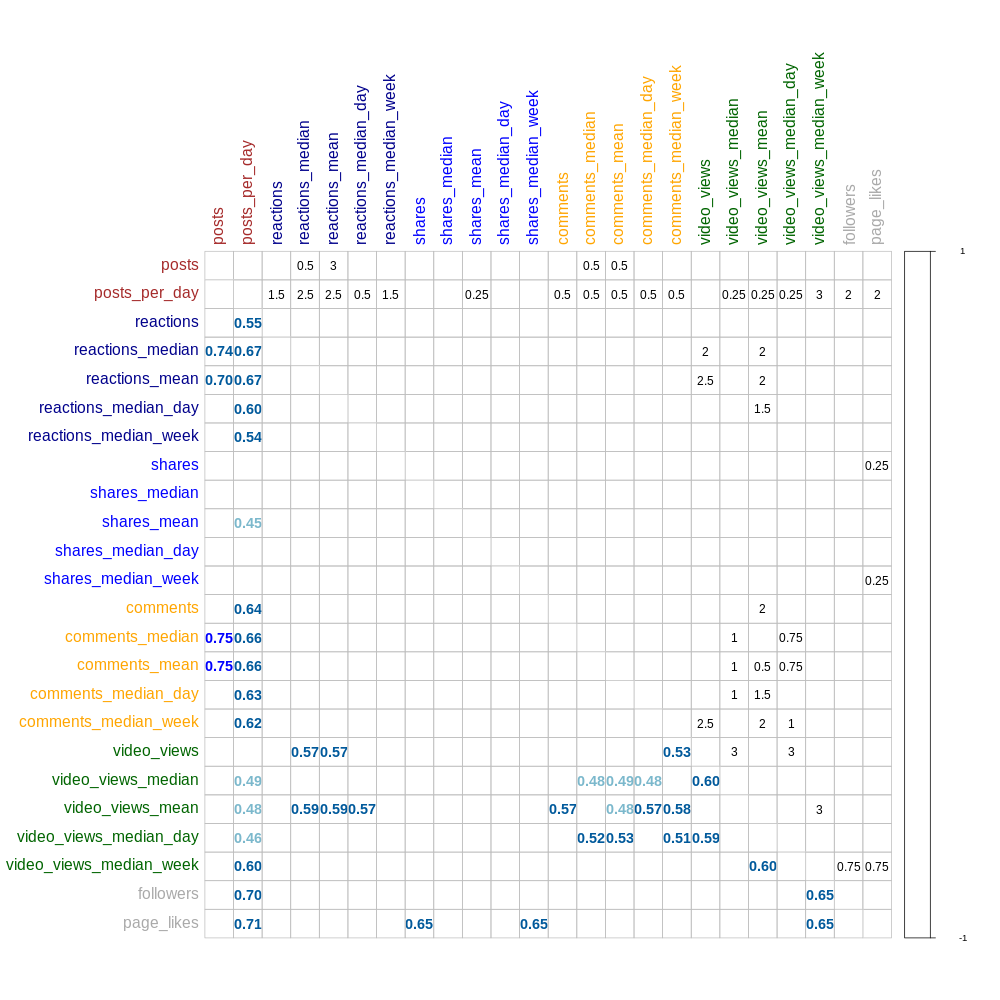

In [ ]:
%%R -w 1000 -h 1000 -u px

try(
corrplot.mixed(r2_values_copy_ideo, upper = "square", tl.col= colors_[2:25], diag = NULL, tl.pos = "lt",  tl.cex = 1.3,
               upper.col=colorRampPalette(c("white"))(40),
               lower.col=colorRampPalette(c("red","gray", "lightblue", "lightblue", "lightblue", "deepskyblue4", "blue"))(8),
                 p.mat = p_values_copy_ideo, insig = "p-value", sig.level = 0,na.label = "square", na.label.col = "white", number.cex = 1.2)
, silent=TRUE)


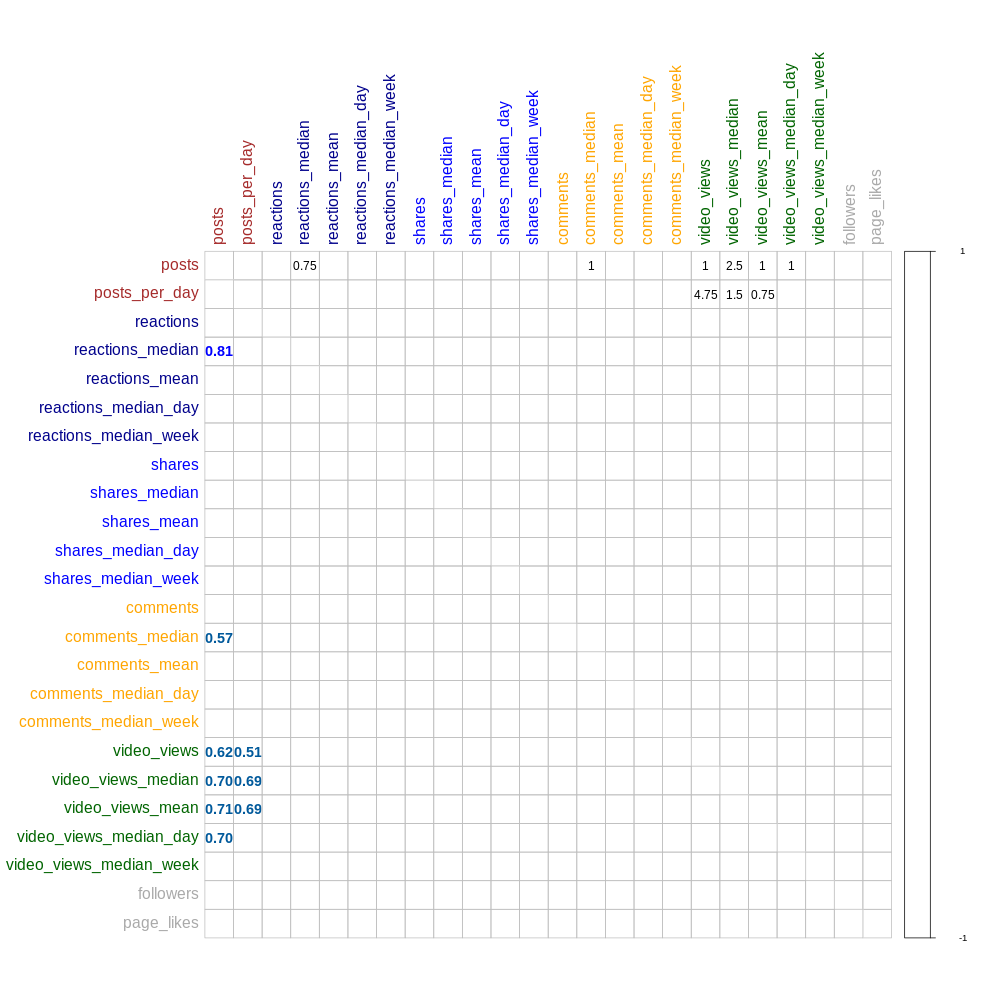

In [ ]:
%%R -w 1000 -h 1000 -u px

try(
corrplot.mixed(r2_values_copy, upper = "square", tl.col= colors_[2:25], diag = NULL, tl.pos = "lt",  tl.cex = 1.3,
               upper.col=colorRampPalette(c("white"))(40),
               lower.col=colorRampPalette(c("red","gray", "lightblue", "lightblue", "lightblue", "deepskyblue4", "blue"))(8),
                 p.mat = p_values_copy, insig = "p-value", sig.level = 0,na.label = "square", na.label.col = "white", number.cex = 1.2)
, silent = TRUE)

In [ ]:
%%R -w 1000 -h 1000 -u px
pdf(file = "Figure6a.pdf", width=13.5, heigh=13.5)
try(
corrplot.mixed(r2_values_copy_ideo, upper = "square", tl.col= colors_[2:25], diag = NULL, tl.pos = "lt",  tl.cex = 1.3,
               upper.col=colorRampPalette(c("white"))(40),
               lower.col=colorRampPalette(c("red","gray", "lightblue", "lightblue", "lightblue", "deepskyblue4", "blue"))(8),
                 p.mat = p_values_copy_ideo, insig = "p-value", sig.level = 0,na.label = "square", na.label.col = "white", number.cex = 1.2)
, silent=TRUE)
dev.off()

png 
  2 


In [ ]:
%%R -w 1000 -h 1000 -u px
pdf(file = "Figure6b.pdf", width=13.5, heigh=13.5)
try(
corrplot.mixed(r2_values_copy, upper = "square", tl.col= colors_[2:25], diag = NULL, tl.pos = "lt",  tl.cex = 1.3,
               upper.col=colorRampPalette(c("white"))(40),
               lower.col=colorRampPalette(c("red","gray", "lightblue", "lightblue", "lightblue", "deepskyblue4", "blue"))(8),
                 p.mat = p_values_copy, insig = "p-value", sig.level = 0,na.label = "square", na.label.col = "white", number.cex = 1.2)
, silent = TRUE)
dev.off()

png 
  2 


In [ ]:
%%R

divisions <- list(c(1,2), c(3:7), c(8:12), c(13:17), c(18:22), c(23:24))

get_best_models <- function(r2_values,months_matrix, truth_variable, matrix_type, rmse_cv){
  r2_values_copy_new <- r2_values
  r2_values_copy_new[is.na(r2_values_copy_new)] = 0
  r2_values_copy_new <- round(r2_values_copy_new, digits = 6)
  print("Best models")
  for(i in 0:50){
      indexes <- (which(r2_values_copy_new == max(r2_values_copy_new), arr.ind = TRUE))

      indexes_table <- data.table(indexes)
      if(r2_values_copy_new[indexes][1] == 0){
          next
      }

      print(paste(colnames(r2_values_copy_new)[indexes_table$col][1],
                  rownames(r2_values_copy_new)[indexes_table$row][1], round( r2_values_copy_new[indexes][1] , 3), "&", round( rmse_cv[indexes][1], 3), "&",
                   months_matrix[indexes][1] ))
      m = months_matrix[indexes][1]
      reload_all_data(as.Date("2019-05-21") - 30 * m, as.Date("2019-05-21"))
      matrix_variable <- get(matrix_type) %>% select(truth_variable,colnames(r2_values_copy_new)[indexes_table$col][1],rownames(r2_values_copy_new)[indexes_table$row][1] ) %>% rename(truth = truth_variable)
      new_lm <- lm(formula = truth ~ ., data=matrix_variable)
      print(summary(new_lm))
      print("-----------------------------------------------------------")
      r2_values_copy_new[indexes] = 0

      for(j in divisions){
          if(sum(indexes_table$col[[1]] %in% j)){
              col_group <- j        
          }
          if(sum(indexes_table$row[[1]] %in% j)){
              row_group <- j        
          }
      }

      for(col in col_group){
          for(row in row_group){
              r2_values_copy_new[col,row] = 0
              r2_values_copy_new[row,col] = 0
          }
      }


  }
}

First line of each model are the Cross validation results

In [ ]:
%R get_best_models(r2_values_copy,m_values_pol, "dalton", "pol_matrix", rmse_cv_pol)

[1] "Best models"
[1] "posts reactions_median 0.808 & 0.424 & 0.75"

Call:
lm(formula = truth ~ ., data = matrix_variable)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.75456 -0.20649 -0.01835  0.15495  1.36666 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.79287    0.37929   2.090   0.0469 *  
posts             0.21043    0.09553   2.203   0.0370 *  
reactions_median  0.54633    0.08374   6.524 7.81e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4369 on 25 degrees of freedom
Multiple R-squared:  0.7804,	Adjusted R-squared:  0.7628 
F-statistic: 44.41 on 2 and 25 DF,  p-value: 5.907e-09

[1] "-----------------------------------------------------------"
[1] "posts video_views_mean 0.708 & 0.531 & 1"

Call:
lm(formula = truth ~ ., data = matrix_variable)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.92449 -0.32698 -0.02731  0.20037  1.50969 

Coefficients:


In [ ]:
%R get_best_models(r2_values_copy_ideo,m_values_ideo, "ideology_by_votes", "ideo_matrix", rmse_cv_ideo)

[1] "Best models"
[1] "posts comments_mean 0.752 & 0.287 & 0.5"

Call:
lm(formula = truth ~ ., data = matrix_variable)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53523 -0.20695 -0.02195  0.15117  0.66794 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.06144    0.40306   5.114 2.77e-05 ***
posts          0.50368    0.07600   6.628 6.06e-07 ***
comments_mean  0.12300    0.05156   2.386   0.0249 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2894 on 25 degrees of freedom
Multiple R-squared:  0.7432,	Adjusted R-squared:  0.7226 
F-statistic: 36.17 on 2 and 25 DF,  p-value: 4.171e-08

[1] "-----------------------------------------------------------"
[1] "posts reactions_median 0.735 & 0.292 & 0.5"

Call:
lm(formula = truth ~ ., data = matrix_variable)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.64361 -0.17964 -0.01989  0.13639  0.66158 

Coefficients:
              

In [ ]:
%%R
set.seed(313)
m=0.5
reload_all_data(as.Date("2019-05-21") - 30 * m, as.Date("2019-05-21"))


  train.control <- trainControl(method = "repeatedcv", number = 5, repeats = 100)  
                    # Train the model

    new_lm <- train(ideology_by_votes ~ posts + comments_mean, data = ideo_matrix, method = "lm",trControl = train.control)
    print(new_lm)
    print(summary(new_lm))

    model_r2_value <- as.numeric(new_lm$results[3])
    model_p_value <- max(summary(new_lm)$coefficients[,4])

print(model_r2_value)



In [ ]:
%%R
set.seed(313)
m=0.75
reload_all_data(as.Date("2019-05-21") - 30 * m, as.Date("2019-05-21"))


  train.control <- trainControl(method="LOOCV")#(method = "repeatedcv", number = 5, repeats = 500)
  train.control <- trainControl(method = "repeatedcv", number = 5, repeats = 100)  
                    # Train the model

    new_lm <- train(dalton ~ posts + reactions_median, data = pol_matrix, method = "lm",trControl = train.control)
    print(new_lm)
    print(summary(new_lm))

    model_r2_value <- as.numeric(new_lm$results[3])
    model_p_value <- max(summary(new_lm)$coefficients[,4])

print(model_r2_value)

## Validation

In [ ]:
%%R
# Choose the number of months before the election 
days <- c(8,15,23,30, 45, 60, 75, 90, 105, 120, 135, 143)

r2_mse_information <- data.table(CJ("days"= days,"model"=c("I1","P1")), "RMSE"=0, "R2"=0)
i <- 1
for(d in days){

  print(d)
  reload_all_data(as.Date("2019-05-21") - d, as.Date("2019-05-21"))

  train.control <-trainControl(method = "repeatedcv", number = 5, repeats = 100)
  set.seed(313)
  new_lm1 <- train(ideology_by_votes ~ posts + comments_mean, data = ideo_matrix, method = "lm", trControl = train.control)
  new_lm2 <- train(dalton ~ posts + reactions_median, data = pol_matrix, method = "lm", trControl = train.control)


  r2_mse_information[days==d&model=="I1"]$RMSE <- as.numeric(new_lm1$results[2])
  r2_mse_information[days==d&model=="P1"]$RMSE <- as.numeric(new_lm2$results[2])

  r2_mse_information[days==d&model=="I1"]$R2 <- as.numeric(new_lm1$results[3])
  r2_mse_information[days==d&model=="P1"]$R2 <- as.numeric(new_lm2$results[3])

  
}
r2_mse_information_copy <- r2_mse_information
r2_mse_information_copy_ideo <- r2_mse_information

[1] 8
[1] 15
[1] 23
[1] 30
[1] 45
[1] 60
[1] 75
[1] 90
[1] 105
[1] 120
[1] 135
[1] 143


In [ ]:
%R r2_mse_information %>% filter(model=="I1")

days model      RMSE        R2
1     8.0    I1  0.307965  0.730341
2    15.0    I1  0.287327  0.751624
3    23.0    I1  0.297775  0.731952
4    30.0    I1  0.290557  0.742671
5    45.0    I1  0.296624  0.735008
6    60.0    I1  0.298367  0.739826
7    75.0    I1  0.307549  0.722470
8    90.0    I1  0.314448  0.708308
9   105.0    I1  0.316959  0.704526
10  120.0    I1  0.321919  0.698649
11  135.0    I1  0.325395  0.693365
12  143.0    I1  0.327265  0.689887

R[write to console]: Saving 9.72 x 8.33 in image

R[write to console]: Saving 9.72 x 8.33 in image



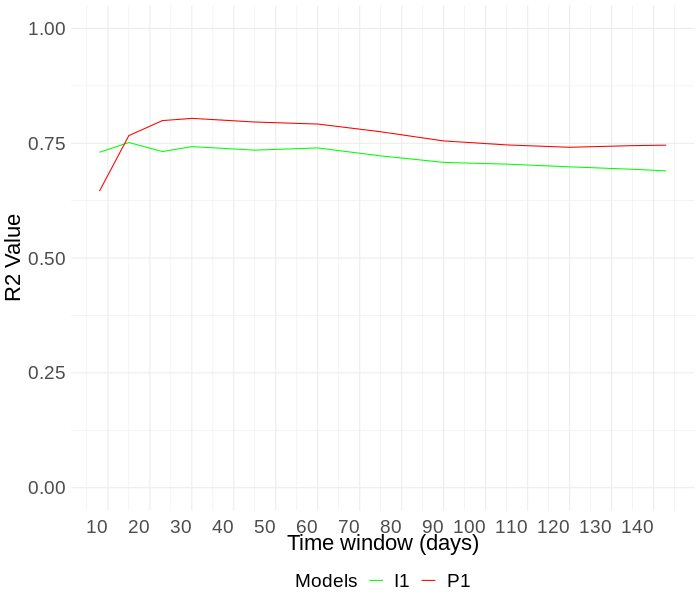

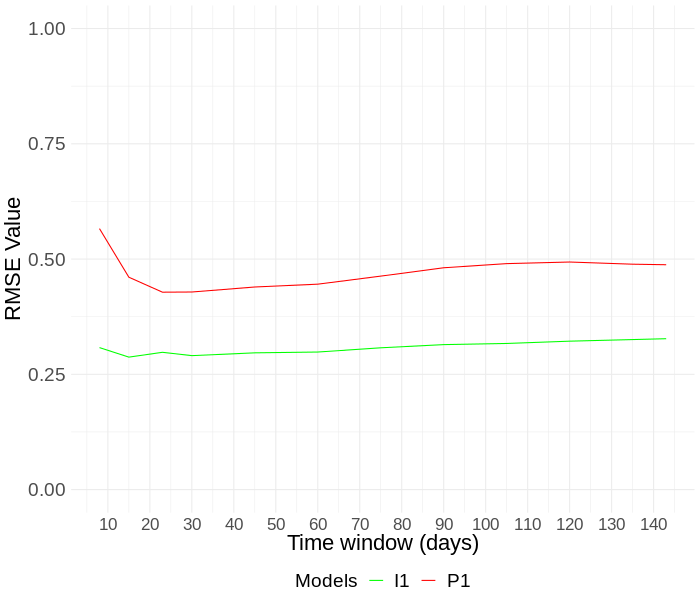

In [ ]:
%%R -w 700 -h 600 -u px

r2_mse_information <- r2_mse_information_copy

plot1 <- ggplot(r2_mse_information) +
    aes(x = days, na.rm=TRUE, group=as.factor(model)) +
    geom_line(aes(y=R2, color=as.factor(model)), outlier.shape = NA) +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 12)) +
    labs(x = "Time window (days)", y = "R2 Value", color="Models") +
    scale_colour_manual(values=c("green","red","blue", "purple")) +
    ylim(0,1) +
    theme_minimal() + theme(axis.text.x = element_text(vjust = 0, hjust=1, size=19), axis.text.y = element_text(size=19),
                            axis.title.y = element_text(size=22), axis.title.x = element_text(size=22), legend.text=element_text(size=19), legend.title=element_text(size=19), legend.position="bottom")
print(plot1)
ggsave(plot1, filename="Figure7a.pdf")
plot2 <- ggplot(r2_mse_information) +
    aes(x = days, na.rm=TRUE, group=as.factor(model)) +
    geom_line(aes(y=RMSE, color=as.factor(model)), outlier.shape = NA) +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 12)) +
    labs(x = "Time window (days)", y = "RMSE Value", color="Models") +
    scale_colour_manual(values=c("green","red","blue", "purple")) +
    ylim(0,1) +
    theme_minimal() + theme(axis.text.x = element_text(size=17), axis.text.y = element_text(size=19),
                            axis.title.y = element_text(size=22), axis.title.x = element_text(size=22), legend.text=element_text(size=19), legend.title=element_text(size=19), legend.position="bottom")


print(plot2)
ggsave(plot2, filename="Figure7b.pdf")


In [ ]:
%R r2_mse_information_copy %>% arrange(model)

days model      RMSE        R2
1     8.0    I1  0.307965  0.730341
2    15.0    I1  0.287327  0.751624
3    23.0    I1  0.297775  0.731952
4    30.0    I1  0.290557  0.742671
5    45.0    I1  0.296624  0.735008
6    60.0    I1  0.298367  0.739826
7    75.0    I1  0.307549  0.722470
8    90.0    I1  0.314448  0.708308
9   105.0    I1  0.316959  0.704526
10  120.0    I1  0.321919  0.698649
11  135.0    I1  0.325395  0.693365
12  143.0    I1  0.327265  0.689887
13    8.0    P1  0.566007  0.645829
14   15.0    P1  0.460591  0.766732
15   23.0    P1  0.428173  0.799375
16   30.0    P1  0.428562  0.804190
17   45.0    P1  0.439426  0.796268
18   60.0    P1  0.445564  0.791803
19   75.0    P1  0.463035  0.774997
20   90.0    P1  0.481145  0.755024
21  105.0    P1  0.490117  0.746393
22  120.0    P1  0.493595  0.741245
23  135.0    P1  0.488872  0.744818
24  143.0    P1  0.487704  0.745840

# Validation with parliament elections


In [ ]:
%%R

ideology_percentage <- function(election, percentage){
    total_vote_share <- 0
    ideology_percentage <- 0

  

    if(percentage > sum(election$vote_share)){
        percentage = sum(election$vote_share)
    }

    for(index in seq(election$left_right)){
      if(total_vote_share + election$vote_share[index] > percentage){
          to_add = percentage - total_vote_share
          
      }else{
          to_add = election$vote_share[index]
      }
      total_vote_share <- total_vote_share + to_add
      
      ideology_percentage <- ideology_percentage + election$left_right[index] * to_add / percentage
      
      if(total_vote_share >= percentage){
          break
      }
      
    }
  return(ideology_percentage)
}

In [ ]:
%%R 

getParliamentElection <- function(country, elec){

    view_election <- read.csv("view_election.csv", encoding="UTF8")
    elections_country <- view_election %>% filter(country_name==country) %>% filter(election_type=="parliament")

    elections_country <- elections_country %>% filter(as.character(as.Date(election_date), format="%Y-%m-%d")==elec)
   
    return(elections_country)

}
elect <- getParliamentElection("Spain", "2019-11-10") %>% filter(!is.na(left_right)) %>% filter(!is.na(vote_share))
elect <- elect[order(-elect$left_right),]

print(ideology_percentage(elect, 100))
print(weighted.mean(elect$left_right, elect$vote_share, na.rm=TRUE) )

[1] 5.270574
[1] 5.270574


In [ ]:
%%R 
view_election <- read.csv("view_election.csv", encoding="UTF8")

## Dummy model


In [ ]:
%%R

getPreviousEuropeanElection <- function(country, date){
    
  view_election <- read.csv("view_election.csv", encoding="UTF8")

  elections_country <- view_election %>% filter(country_name==country) %>% filter(election_type=="ep")
  elections_country <- elections_country %>% filter(as.Date(election_date) < as.Date(date))
  elections_country <- elections_country %>% filter(election_date == max(election_date))
    
  return(elections_country)
}

In [ ]:
%%R
countries_with_elections = c("Austria", "Belgium", "Croatia", "Finland", "Estonia", "Denmark", "Spain", "United Kingdom", "Greece", "Ireland", "Lithuania", "Poland", "Portugal", "Romania", "Slovakia" )

parliament_elections = data.table("country_name" = countries_with_elections, "ideology"=0, "dalton"=0)
eu_election_results = data.table("country_name" = countries_with_elections, "ideology"=0, "dalton"=0)

for(country in countries_with_elections){
  election_date = as.Date(unique((view_election %>% filter(country_name == country) %>% filter(election_type=="parliament") %>% arrange(election_date))$election_date) %>% last())

  parliament_election <- getParliamentElection(country, election_date) %>% filter(!is.na(left_right)) %>% filter(!is.na(vote_share))
  parliament_elections[country_name==country]$ideology = weighted.mean(parliament_election$left_right, parliament_election$vote_share, na.rm=TRUE) 
  parliament_elections[country_name==country]$dalton = calculate_dalton(data.table(parliament_election %>% rename(variable = vote_share, ideology=left_right)))

  country_election <- getPreviousEuropeanElection(country, election_date) %>% filter(!is.na(vote_share)) %>% filter(!is.na(left_right))
  eu_election_results[country_name==country]$ideology = weighted.mean(country_election$left_right, country_election$vote_share, na.rm=TRUE) 
  eu_election_results[country_name==country]$dalton = calculate_dalton(data.table(country_election %>% rename(variable = vote_share, ideology=left_right)))
}


In [ ]:
%R eu_election_results %>% mutate(ideology=round(ideology,digits=3), dalton=round(dalton,3)) %>% arrange(country_name)

country_name  ideology  dalton
1          Austria     5.487   3.959
2          Belgium     5.353   4.130
3          Croatia     5.512   4.166
4          Denmark     4.970   4.727
5          Estonia     6.105   4.071
6          Finland     5.530   3.426
7           Greece     4.978   4.625
8          Ireland     4.548   4.036
9        Lithuania     5.134   4.192
10          Poland     6.837   2.495
11        Portugal     4.507   3.825
12         Romania     5.362   2.401
13        Slovakia     6.335   3.278
14           Spain     5.103   4.504
15  United Kingdom     5.940   4.817

In [ ]:
%%R
parliament_elections 

      country_name ideology dalton
 1:        Austria    5.512  3.928
 2:        Belgium    5.324  5.005
 3:        Croatia    5.894  4.385
 4:        Finland    5.353  3.485
 5:        Estonia    5.842  3.886
 6:        Denmark    5.260  4.666
 7:          Spain    5.271  5.195
 8: United Kingdom    5.722  3.447
 9:         Greece    4.781  4.371
10:        Ireland    4.583  3.645
11:      Lithuania    5.283  3.938
12:         Poland    6.351  3.383
13:       Portugal    4.580  3.627
14:        Romania    5.441  3.364
15:       Slovakia    6.465  3.720


In [ ]:
%%R
error_matrix = data.table("country_name" = countries_with_elections, "ideology"=0, "dalton"=0)
for(country in countries_with_elections){
  error_matrix[country_name==country]$ideology =  parliament_elections[country_name==country]$ideology -  eu_election_results[country_name==country]$ideology
  error_matrix[country_name==country]$dalton =  parliament_elections[country_name==country]$dalton -  eu_election_results[country_name==country]$dalton
}
error_matrix

      country_name    ideology      dalton
 1:        Austria  0.02537216 -0.03126750
 2:        Belgium -0.02833453  0.87492066
 3:        Croatia  0.38191899  0.21903686
 4:        Finland -0.17621758  0.05942130
 5:        Estonia -0.26336606 -0.18542209
 6:        Denmark  0.29017492 -0.06060358
 7:          Spain  0.16802336  0.69046110
 8: United Kingdom -0.21868411 -1.36928673
 9:         Greece -0.19720271 -0.25344259
10:        Ireland  0.03538818 -0.39089341
11:      Lithuania  0.14855966 -0.25439087
12:         Poland -0.48564645  0.88774621
13:       Portugal  0.07262756 -0.19741010
14:        Romania  0.07812410  0.96283962
15:       Slovakia  0.12996903  0.44203825


In [ ]:
%R error_matrix %>% mutate(ideology=round(ideology,3), dalton=round(dalton,3)) %>% arrange(country_name)

country_name  ideology  dalton
1          Austria     0.025  -0.031
2          Belgium    -0.028   0.875
3          Croatia     0.382   0.219
4          Denmark     0.290  -0.061
5          Estonia    -0.263  -0.185
6          Finland    -0.176   0.059
7           Greece    -0.197  -0.253
8          Ireland     0.035  -0.391
9        Lithuania     0.149  -0.254
10          Poland    -0.486   0.888
11        Portugal     0.073  -0.197
12         Romania     0.078   0.963
13        Slovakia     0.130   0.442
14           Spain     0.168   0.690
15  United Kingdom    -0.219  -1.369

In [ ]:
%%R

print(paste("Dummy ideology RMSE: ",RMSE( parliament_elections$ideology, eu_election_results$ideology)))
print(paste("Dummy polarization RMSE: ",RMSE( parliament_elections$dalton, eu_election_results$dalton)))

[1] "Dummy ideology RMSE:  0.221255938875521"
[1] "Dummy polarization RMSE:  0.602161453694011"


## Time analysis with fitting the model with the best month fit 



In [ ]:
%%R
countries_with_elections = c("Austria", "Belgium", "Croatia", "Finland", "Estonia", "Denmark", "Spain", "United Kingdom", "Greece", "Ireland", "Lithuania", "Poland", "Portugal", "Romania", "Slovakia" )
countries_ideology <- pol_matrix %>% filter((country_name) %in% (countries_with_elections))
countries_ideology_copy <- countries_ideology

In [ ]:
%%R


evaluate_parliament_elections <- function(model, matrix_variable, ideology_perc=100){
    
  r2_mse_information_M <- data.table("country"=countries_with_elections, "RMSE"=0, "Prediction"=0, "Real"=0)
  truth_dt <- data.table("country"=countries_with_elections,"truth"=0.0) # Truth data table to check the RMSE and R2 at the end
  countries_ideology <- copy(get(matrix_variable)) %>% filter((country_name) %in% (countries_with_elections))
  print("Loading countries")
  for(coun in countries_with_elections){
      election_date = as.Date(unique((view_election %>% filter(country_name == coun) %>% filter(election_type=="parliament") %>% arrange(election_date))$election_date) %>% last())
      print(paste(coun,election_date))

      parliament_election <- getParliamentElection(coun, election_date) %>% filter(!is.na(left_right)) %>% filter(!is.na(vote_share))
      parliament_election <- parliament_election[order(parliament_election$left_right),]

      reload_all_data(election_date - 30 * m - 2, election_date - 2, coun)

      countries_ideology[country_name==coun] = countries_ideology[country_name==coun, get(matrix_variable)[get(matrix_variable)$country_name==coun]] 
    
      country_prediction <- predict.lm(model, countries_ideology[country_name==coun])

      if(matrix_variable=="pol_matrix"){
        country_truth <- calculate_dalton(data.table("ideology"=parliament_election$left_right, "variable"=parliament_election$vote_share))  
      }else{
          # if(ideology_perc > 50 && ideology_perc != 100){
          #     perc = 100 - ideology_perc
          #     parliament_election <- parliament_election[order(-parliament_election$left_right),]
          # }else{
          #     perc = ideology_perc
          # }
          country_truth <- ideology_percentage(parliament_election,100)
          print(paste(weighted.mean(parliament_election$left_right, parliament_election$vote_share), country_truth))
      }  
      truth_dt[country==coun]$truth <- country_truth

      r2_mse_information_M[country==coun]$RMSE <- RMSE(country_prediction[[1]],country_truth)
      r2_mse_information_M[country==coun]$Prediction <- country_prediction[[1]]
      r2_mse_information_M[country==coun]$Real <- country_truth
  }
  print(" --- Model results: ---")
  # Everthing is order alphab., if not the results won't be accurate!
  prediction <- predict.lm(model, countries_ideology)
  result_data = data.table(countries_ideology[order(country)], prediction)

  truth <- unlist(truth_dt[order(country)] %>% select("truth"),use.names = FALSE)
  print(paste("MSE:",mean((truth - prediction) ^ 2)))
  print(paste("RMSE:",RMSE(truth, prediction)))
  print(paste("R2",R2(prediction, truth)))
  return(r2_mse_information_M[order(country)])

}


evaluate_parliament_elections <- function(model, matrix_variable, ideology_perc=100){
  r2_mse_information_M <- data.table("country"=countries_with_elections, "RMSE"=0, "Prediction"=0, "Real"=0)

  print("Loading countries")
  for(coun in countries_with_elections){
      election_date = as.Date(unique((view_election %>% filter(country_name == coun) %>% filter(election_type=="parliament") %>% arrange(election_date))$election_date) %>% last())
      print(paste(coun,election_date))

      parliament_election <- getParliamentElection(coun, election_date) %>% filter(!is.na(left_right)) %>% filter(!is.na(vote_share))
      parliament_election <- parliament_election[order(parliament_election$left_right),]

      reload_all_data(election_date - 30 * m - 2, election_date - 2, coun)
    
      country_prediction <- predict.lm(model, get(matrix_variable) %>% filter(country_name == coun))

      if(matrix_variable=="pol_matrix"){
        country_truth <- calculate_dalton(data.table("ideology"=parliament_election$left_right, "variable"=parliament_election$vote_share))  
      }else{
        country_truth <- weighted.mean(parliament_election$left_right, parliament_election$vote_share)
      }  


      r2_mse_information_M[country==coun]$RMSE <- RMSE(country_prediction[[1]],country_truth)
      r2_mse_information_M[country==coun]$Prediction <- country_prediction[[1]]
      r2_mse_information_M[country==coun]$Real <- country_truth
  }
  print(" --- Model results: ---")
  # Everthing is order alphab., if not the results won't be accurate!

  print(paste("RMSE:",RMSE(r2_mse_information_M$Real, r2_mse_information_M$Prediction)))
  print(paste("R2",R2(r2_mse_information_M$Real, r2_mse_information_M$Prediction)))
  return(r2_mse_information_M[order(country)])

}

In [ ]:
%%R

election <- data.table(vote_share=c(26.4,22.5+6,14      ,8.7    ,10.1,5,    2.9)
                      ,left_right=c(3.6451,6.2503,2.9308,5.9233,8.8, 1.2152,7.4))
print(election  %>% mutate(variable=vote_share))
print(ideology_percentage(election, 100))
print(calculate_dalton(election  %>% mutate(variable=as.double(vote_share), ideology=left_right)))

   vote_share left_right variable
1:       26.4     3.6451     26.4
2:       28.5     6.2503     28.5
3:       14.0     2.9308     14.0
4:        8.7     5.9233      8.7
5:       10.1     8.8000     10.1
6:        5.0     1.2152      5.0
7:        2.9     7.4000      2.9
[1] 5.055901
[1] 4.061495


In [ ]:
%%R

evaluate_parliament_elections_party_percentages <- function(){
  r2_mse_information_M <- data.table("country"=countries_with_elections, "MAE"=0, "MAE2"=0)

  print("Loading countries")
  for(coun in countries_with_elections){
      election_date = as.Date(unique((view_election %>% filter(country_name == coun) %>% filter(election_type=="parliament") %>% arrange(election_date))$election_date) %>% last())
      print(paste(coun,election_date))

      parliament_election <- getParliamentElection(coun, election_date) %>% filter(!is.na(left_right)) %>% filter(!is.na(vote_share))
      parliament_election <- parliament_election[order(parliament_election$left_right),]

      print(coun)
      load_initial_data(election_date - 30 * m - 2, election_date - 2, coun)
    
      #country_prediction <- predict.lm(model, get(matrix_variable) %>% filter(country_name == coun))
      posts_per_party <- data.table(posts_data_act) %>% group_by(party_id) %>% summarise(posts = length(post_id), reac = median(reaction_count), com = mean(comments))  %>%
                          inner_join(parliament_election %>% select(party_id, vote_share), by="party_id") %>%
                          mutate(posts = posts/sum(posts) * 100, reac= reac/sum(reac) * 100, com = com / sum(com) * 100, vote_share=vote_share/sum(vote_share) * 100)

      posts_per_party <- posts_per_party %>% mutate(vote_share1 = 0.79287 +  posts * 0.21043 + reac * 0.54633, vote_share2 = 2.06144 + posts * 0.50368 + com * 0.12300) %>% mutate(vote_share1 = vote_share1/sum(vote_share1) * 100, vote_share2 = vote_share2/sum(vote_share2) * 100)
      print(posts_per_party)

      print(mean(abs(posts_per_party$vote_share1  - posts_per_party$vote_share)))


      r2_mse_information_M[country==coun]$MAE <- (mean(abs(posts_per_party$vote_share1  - posts_per_party$vote_share)))
      r2_mse_information_M[country==coun]$MAE2 <- (mean(abs(posts_per_party$vote_share2  - posts_per_party$vote_share)))
  }

  return(r2_mse_information_M[order(country)])

}

### Dalton polarization


In [ ]:
%%R

print("Loading data to fit the polarization lm model")

m = 0.75

reload_all_data(as.Date("2019-05-21") - 30 * m, as.Date("2019-05-21"))

dalton_linear_lm <- lm(formula = dalton ~ reactions_median + posts, data=pol_matrix)
print(VIF(dalton_linear_lm))
print(summary(dalton_linear_lm))
print(sqrt(mean(dalton_linear_lm$residuals^2)))
rmse_info <- evaluate_parliament_elections_party_percentages()
print(mean(rmse_info$MAE))
print(mean(rmse_info$MAE2))
#r2_mse_information_pol <- evaluate_parliament_elections(dalton_linear_lm, "pol_matrix")

[1] "Loading data to fit the polarization lm model"
reactions_median            posts 
          1.4113           1.4113 

Call:
lm(formula = dalton ~ reactions_median + posts, data = pol_matrix)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.75456 -0.20649 -0.01835  0.15495  1.36666 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.79287    0.37929   2.090   0.0469 *  
reactions_median  0.54633    0.08374   6.524 7.81e-07 ***
posts             0.21043    0.09553   2.203   0.0370 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4369 on 25 degrees of freedom
Multiple R-squared:  0.7804,	Adjusted R-squared:  0.7628 
F-statistic: 44.41 on 2 and 25 DF,  p-value: 5.907e-09

[1] 0.4128526
[1] "Loading countries"
[1] "Austria 2019-09-29"
[1] "Austria"
[1] "Total posts wihtout filters: 16082"
[1] "Total posts with date filters: 357"
# A tibble: 5 × 7
  party_id posts  reac   com vote_sha

In [ ]:
%R rmse_info

country        MAE       MAE2
1          Austria  10.210126  10.531855
2          Belgium   3.470896   3.072253
3          Croatia   8.887137   9.459009
4          Denmark   5.465981   5.869791
5          Estonia  11.808699  10.069314
6          Finland   5.869547   6.452737
7           Greece  11.395401  16.561726
8          Ireland  11.806517  11.077782
9        Lithuania   3.735282   7.450736
10          Poland   8.520260   6.381907
11        Portugal   8.856834  13.720985
12         Romania  10.604226   6.904289
13        Slovakia   2.369996   5.570307
14           Spain   9.324035   8.231421
15  United Kingdom   9.820835   9.634318

In [ ]:
%%R

print("Loading data to fit the polarization lm model")
m = 0.75
# m = 1.25

reload_all_data(as.Date("2019-05-21") - 30 * m, as.Date("2019-05-21"))
# pol_matrix <- pol_matrix %>% left_join(eu_population, by="country_name")
dalton_linear_lm <- lm(formula = dalton ~ posts + reactions_median, data=pol_matrix)
# dalton_linear_lm <- lm(formula = dalton ~ video_views_mean + posts_per_day, data=pol_matrix, weights = X2019)

print(summary(dalton_linear_lm))
print(sqrt(mean(dalton_linear_lm$residuals^2)))

r2_mse_information_pol <- evaluate_parliament_elections(dalton_linear_lm, "pol_matrix")

[1] "Loading data to fit the polarization lm model"

Call:
lm(formula = dalton ~ posts + reactions_median, data = pol_matrix)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.75456 -0.20649 -0.01835  0.15495  1.36666 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.79287    0.37929   2.090   0.0469 *  
posts             0.21043    0.09553   2.203   0.0370 *  
reactions_median  0.54633    0.08374   6.524 7.81e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4369 on 25 degrees of freedom
Multiple R-squared:  0.7804,	Adjusted R-squared:  0.7628 
F-statistic: 44.41 on 2 and 25 DF,  p-value: 5.907e-09

[1] 0.4128526
[1] "Loading countries"
[1] "Austria 2019-09-29"
[1] "Total posts wihtout filters: 16082"
[1] "Total posts with date filters: 357"
[1] "Belgium 2019-05-26"
[1] "Total posts wihtout filters: 23840"
[1] "Total posts with date filters: 841"
[1] "Croatia 2020-07-05"
[1] "To

In [ ]:
%R r2_mse_information_pol %>% mutate(RMSE=round(RMSE,3), Prediction=round(Prediction,3), Real=round(Real,3)) %>% arrange(country)

country   RMSE  Prediction   Real
1          Austria  0.058       3.986  3.928
2          Belgium  0.335       4.670  5.005
3          Croatia  0.118       4.503  4.385
4          Denmark  0.087       4.753  4.666
5          Estonia  0.454       3.432  3.886
6          Finland  0.198       3.683  3.485
7           Greece  0.302       4.070  4.371
8          Ireland  0.274       3.371  3.645
9        Lithuania  0.158       4.096  3.938
10          Poland  0.054       3.436  3.383
11        Portugal  0.095       3.532  3.627
12         Romania  0.124       3.488  3.364
13        Slovakia  0.129       3.591  3.720
14           Spain  0.214       5.409  5.195
15  United Kingdom  0.658       4.106  3.447

### Country Ideology

In [ ]:
%%R

print("Loading data to fit the polarization lm model")
m = 0.5
reload_all_data(as.Date("2019-05-21") - 30 * m, as.Date("2019-05-21"))

ideo_linear_lm <- lm(formula = ideology_by_votes ~ posts + comments_mean, data=ideo_matrix)
print(summary(ideo_linear_lm))
print(sqrt(mean(ideo_linear_lm$residuals^2)))

r2_mse_information_ideo <- evaluate_parliament_elections(ideo_linear_lm, "ideo_matrix")

[1] "Loading data to fit the polarization lm model"

Call:
lm(formula = ideology_by_votes ~ posts + comments_mean, data = ideo_matrix)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53523 -0.20695 -0.02195  0.15117  0.66794 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.06144    0.40306   5.114 2.77e-05 ***
posts          0.50368    0.07600   6.628 6.06e-07 ***
comments_mean  0.12300    0.05156   2.386   0.0249 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2894 on 25 degrees of freedom
Multiple R-squared:  0.7432,	Adjusted R-squared:  0.7226 
F-statistic: 36.17 on 2 and 25 DF,  p-value: 4.171e-08

[1] 0.2734786
[1] "Loading countries"
[1] "Austria 2019-09-29"
[1] "Belgium 2019-05-26"
[1] "Croatia 2020-07-05"
[1] "Finland 2019-04-14"
[1] "Estonia 2019-03-03"
[1] "Denmark 2019-06-05"
[1] "Spain 2019-11-10"
[1] "United Kingdom 2019-12-12"
[1] "Greece 2019-07-07"
[1] "Ireland 2020-02

In [ ]:
%%R

print("Loading data to fit the polarization lm model")
m = 0.5
reload_all_data(as.Date("2019-05-21") - 30 * m, as.Date("2019-05-21"))

ideo_linear_lm <- lm(formula = ideology_by_votes ~ posts + comments_mean, data=ideo_matrix )
print(summary(ideo_linear_lm))
print(sqrt(mean(ideo_linear_lm$residuals^2)))

r2_mse_information_ideo <- evaluate_parliament_elections(ideo_linear_lm, "ideo_matrix")

[1] "Loading data to fit the polarization lm model"

Call:
lm(formula = ideology_by_votes ~ posts + comments_mean, data = ideo_matrix)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53523 -0.20695 -0.02195  0.15117  0.66794 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.06144    0.40306   5.114 2.77e-05 ***
posts          0.50368    0.07600   6.628 6.06e-07 ***
comments_mean  0.12300    0.05156   2.386   0.0249 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2894 on 25 degrees of freedom
Multiple R-squared:  0.7432,	Adjusted R-squared:  0.7226 
F-statistic: 36.17 on 2 and 25 DF,  p-value: 4.171e-08

[1] 0.2734786
[1] "Loading countries"
[1] "Austria 2019-09-29"
[1] "Belgium 2019-05-26"
[1] "Croatia 2020-07-05"
[1] "Finland 2019-04-14"
[1] "Estonia 2019-03-03"
[1] "Denmark 2019-06-05"
[1] "Spain 2019-11-10"
[1] "United Kingdom 2019-12-12"
[1] "Greece 2019-07-07"
[1] "Ireland 2020-02

In [ ]:
%R r2_mse_information_ideo %>% mutate(Prediction=round(Prediction, digits=3), RMSE=round(RMSE, digits=3))

country   RMSE  Prediction      Real
1          Austria  0.096       5.417  5.512346
2          Belgium  0.196       5.521  5.324405
3          Croatia  0.259       5.635  5.893812
4          Denmark  0.088       5.172  5.260045
5          Estonia  0.609       5.233  5.842042
6          Finland  0.405       5.759  5.353482
7           Greece  0.029       4.752  4.781244
8          Ireland  0.107       4.690  4.582991
9        Lithuania  0.301       4.982  5.282613
10          Poland  0.119       6.233  6.351300
11        Portugal  0.274       4.306  4.580054
12         Romania  0.352       5.792  5.440572
13        Slovakia  0.360       6.104  6.464610
14           Spain  0.308       4.963  5.270574
15  United Kingdom  0.080       5.802  5.721755

In [ ]:
%%R
election_date = as.Date("2021-09-25")
coun = "Germany"
m = 0.75
reload_all_data(election_date - 30 * m - 2, election_date - 2, coun)
matrix_variable = "pol_matrix"
      pol_prediction <- predict.lm(dalton_linear_lm,   get(matrix_variable)[get(matrix_variable)$country_name==coun][1])
print(pol_prediction)


m = 0.5
reload_all_data(election_date - 30 * m - 2, election_date - 2, coun)
matrix_variable = "ideo_matrix"
      countries_ideology[country_name==coun] = countries_ideology[country_name==coun, get(matrix_variable)[get(matrix_variable)$country_name==coun]] 
      ideo_prediction <- predict.lm(ideo_linear_lm,  get(matrix_variable)[get(matrix_variable)$country_name==coun])

print(ideo_prediction)

## Validation with previous elections

In [ ]:
%R getParliamentElection("Lithuania", "2016-10-09")

country_name_short country_name election_type election_date  vote_share  \
1                 LTU    Lithuania    parliament    2016-10-09       22.45   
2                 LTU    Lithuania    parliament    2016-10-09       22.63   
3                 LTU    Lithuania    parliament    2016-10-09       15.04   
4                 LTU    Lithuania    parliament    2016-10-09        9.45   
5                 LTU    Lithuania    parliament    2016-10-09        5.72   
6                 LTU    Lithuania    parliament    2016-10-09        5.55   
7                 LTU    Lithuania    parliament    2016-10-09         NaN   
8                 LTU    Lithuania    parliament    2016-10-09        4.88   
9                 LTU    Lithuania    parliament    2016-10-09        6.32   
10                LTU    Lithuania    parliament    2016-10-09        2.03   
11                LTU    Lithuania    parliament    2016-10-09        1.80   
12                LTU    Lithuania    parliament    2016-10-09        2.23   
13                LTU    Lithuania    parliament    2016-10-09        1.05   

    seats  seats_total party_name_short  \
1      54          141             LVLS   
2      31          141            TS-LK   
3      17          141             LSDP   
4      14          141             LRLS   
5       8          141             LLRA   
6       8          141           TT-LDP   
7       4          141             none   
8       2          141               DP   
9       1          141              LCP   
10      1          141              LZP   
11      1          141         one-seat   
12      0          141              LLS   
13      0          141          no-seat   

                                           party_name  \
1                         Lietuvos valstiečių sąjunga   
2                                     Tėvynės sąjunga   
3                    Lietuvos socialdemokratų partija   
4               Lietuvos Respublikos liberalų sąjūdis   
5                       Lietuvos lenkų rinkimų akcija   
6   Tvarka ir teisingumas – Liberalų demokratų par...   
7                                no party affiliation   
8                                       Darbo partija   
9                             Lietuvos Centro Partija   
10                           Lietuvos žalioji partija   
11                                           one seat   
12               Lietuvos laisvės sąjunga (liberalai)   
13                                            no seat   

                                party_name_english  left_right  country_id  \
1                         Lithuanian Peasant Union      3.2687          15   
2                                   Homeland Union      7.4004          15   
3               Lithuanian Social Democratic Party      3.1972          15   
4   Liberals Movement of the Republic of Lithuania      7.7562          15   
5             Election Action of Lithuania's Poles      3.8650          15   
6    Order and Justice -- Liberal Democratic Party      5.2955          15   
7                             no party affiliation         NaN          15   
8                                     Labour Party      3.8600          15   
9                          Lithuanian Centre Party      8.8000          15   
10                          Lithuanian Green Party      2.5000          15   
11                                        one seat         NaN          15   
12             Lithuanian Freedom Union (Liberals)      6.0000          15   
13                                         no seat         NaN          15   

    election_id  previous_parliament_election_id  previous_cabinet_id  \
1          1009                              786                 1633   
2          1009                              786                 1633   
3          1009                              786                 1633   
4          1009                              786                 1633   
5          1009                              786  

In [ ]:
%%R 

print_results <- function(prediction, truth){
  print(paste("Prediction:",prediction))
  print(paste("Truth: ", truth))
  print(paste("RMSE:" , RMSE(prediction, truth)))

}

study_election <- function(country, elec_date){
    
  election_to_study <- getParliamentElection(country, elec_date) %>% filter(!is.na(vote_share)) %>% filter(!is.na(left_right))
  election_to_study <- election_to_study[order(election_to_study$left_right),]
  election_date <- as.Date(election_to_study$election_date[1])

  ### Dalton ###
  print("-----------------------------------")
  print("Dalton Polarization")
  m = 0.75
  reload_all_data(election_date - 30 * m - 2, election_date - 2, country)

  country_prediction_pol <- predict.lm(dalton_linear_lm, pol_matrix[country_name==country])
  country_truth_pol <- calculate_dalton(data.table("ideology"=election_to_study$left_right, "variable"=election_to_study$vote_share))
  print_results(country_prediction_pol[[1]],country_truth_pol)

  ### Country Ideology ###
  print("-----------------------------------")
  print("Country Ideology")
  m = 0.5
  reload_all_data(election_date - 30 * m, election_date - 2, country)

  country_prediction <- predict.lm(ideo_linear_lm, ideo_matrix[country_name==country])
  country_truth <- ideology_percentage(election_to_study,100)
  print_results(country_prediction[[1]],country_truth)
  return(data.table(country_name=country, prediction_ideo=country_prediction, real_ideo=country_truth, prediction_pol=country_prediction_pol, real_pol=country_truth_pol))
}

In [ ]:
%%R 
posts_file <- "all_posts_ireland.csv"
load_initial_data("2016-01-01","2018-12-31")

[1] "Total posts wihtout filters: 20427"
[1] "Total posts with date filters: 8976"


In [ ]:
%R results <- study_election("Ireland","2016-02-26")

[1] "-----------------------------------"
[1] "Dalton Polarization"
[1] "Total posts wihtout filters: 20427"
[1] "Total posts with date filters: 671"
[1] "Prediction: 3.22639702871686"
[1] "Truth:  3.61790430960631"
[1] "RMSE: 0.391507280889448"
[1] "-----------------------------------"
[1] "Country Ideology"
[1] "Total posts wihtout filters: 20427"
[1] "Total posts with date filters: 420"
[1] "Prediction: 4.9269899511196"
[1] "Truth:  4.95458099450155"
[1] "RMSE: 0.0275910433819533"


country_name  prediction_ideo  real_ideo  prediction_pol  real_pol
1      Ireland          4.92699   4.954581        3.226397  3.617904

In [ ]:
%%R 
posts_file <- "all_posts_lithuania2.csv"
load_initial_data("2016-01-01","2018-12-31")

[1] "Total posts wihtout filters: 11841"
[1] "Total posts with date filters: 5550"


In [ ]:
%R results <- results %>% union(study_election("Lithuania", "2016-10-09"))

[1] "-----------------------------------"
[1] "Dalton Polarization"
[1] "Total posts wihtout filters: 11841"
[1] "Total posts with date filters: 248"
[1] "Prediction: 3.90886846420489"
[1] "Truth:  4.23682868193894"
[1] "RMSE: 0.327960217734051"
[1] "-----------------------------------"
[1] "Country Ideology"
[1] "Total posts wihtout filters: 11841"
[1] "Total posts with date filters: 145"
[1] "Prediction: 5.43364963725643"
[1] "Truth:  5.26106926272066"
[1] "RMSE: 0.172580374535767"


country_name  prediction_ideo  real_ideo  prediction_pol  real_pol
1      Ireland          4.92699   4.954581        3.226397  3.617904
2    Lithuania          5.43365   5.261069        3.908868  4.236829

In [ ]:
%%R 
posts_file <- "all_posts_spain.csv"
load_initial_data("2016-01-01","2018-12-31")

[1] "Total posts wihtout filters: 79201"
[1] "Total posts with date filters: 43230"


In [ ]:
%R results <- results %>% union(study_election("Spain", "2016-06-26"))

[1] "-----------------------------------"
[1] "Dalton Polarization"
[1] "Total posts wihtout filters: 79201"
[1] "Total posts with date filters: 1967"
[1] "Prediction: 4.26364210097119"
[1] "Truth:  4.93029831656735"
[1] "RMSE: 0.666656215596158"
[1] "-----------------------------------"
[1] "Country Ideology"
[1] "Total posts wihtout filters: 79201"
[1] "Total posts with date filters: 1213"
[1] "Prediction: 5.11963593947776"
[1] "Truth:  4.9351957296115"
[1] "RMSE: 0.184440209866265"


country_name  prediction_ideo  real_ideo  prediction_pol  real_pol
1      Ireland         4.926990   4.954581        3.226397  3.617904
2    Lithuania         5.433650   5.261069        3.908868  4.236829
3        Spain         5.119636   4.935196        4.263642  4.930298

In [ ]:
%%R 
posts_file <- "all_posts_slovakia2.csv"
load_initial_data("2016-01-01","2018-12-31")

[1] "Total posts wihtout filters: 36402"
[1] "Total posts with date filters: 15619"


In [ ]:
%R results <- results %>% union(study_election("Slovakia", "2016-03-06"))

[1] "-----------------------------------"
[1] "Dalton Polarization"
[1] "Total posts wihtout filters: 36402"
[1] "Total posts with date filters: 525"
[1] "Prediction: 3.84859839294373"
[1] "Truth:  3.91948609597375"
[1] "RMSE: 0.0708877030300199"
[1] "-----------------------------------"
[1] "Country Ideology"
[1] "Total posts wihtout filters: 36402"
[1] "Total posts with date filters: 304"
[1] "Prediction: 6.37863012810996"
[1] "Truth:  6.16372549572114"
[1] "RMSE: 0.214904632388813"


country_name  prediction_ideo  real_ideo  prediction_pol  real_pol
1      Ireland         4.926990   4.954581        3.226397  3.617904
2    Lithuania         5.433650   5.261069        3.908868  4.236829
3        Spain         5.119636   4.935196        4.263642  4.930298
4     Slovakia         6.378630   6.163725        3.848598  3.919486

In [ ]:
%%R 
print(paste("Ideo RMSE:", RMSE(results$prediction_ideo, results$real_ideo)))
print(paste("Pol RMSE:", RMSE(results$prediction_pol, results$real_pol)))

[1] "Ideo RMSE: 0.166393692328986"
[1] "Pol RMSE: 0.42139394621882"


In [ ]:
%R getParliamentElection("Slovakia", "2016-03-06") %>% filter(!is.na(vote_share)) %>% filter(!is.na(left_right))

country_name_short country_name election_type election_date  vote_share  \
1                 SVK     Slovakia    parliament    2016-03-06       28.28   
2                 SVK     Slovakia    parliament    2016-03-06       12.10   
3                 SVK     Slovakia    parliament    2016-03-06       11.03   
4                 SVK     Slovakia    parliament    2016-03-06        8.64   
5                 SVK     Slovakia    parliament    2016-03-06        8.04   
6                 SVK     Slovakia    parliament    2016-03-06        6.63   
7                 SVK     Slovakia    parliament    2016-03-06        6.50   
8                 SVK     Slovakia    parliament    2016-03-06        5.61   
9                 SVK     Slovakia    parliament    2016-03-06        4.94   
10                SVK     Slovakia    parliament    2016-03-06        4.05   

    seats  seats_total party_name_short                            party_name  \
1      49          150             Smer            Smer – sociálna demokracia   
2      21          150              SaS                  Sloboda a solidarita   
3      19          150            OLaNO  Obyčajní ľudia a nezávislé osobnosti   
4      15          150              SNS              Slovenská národná strana   
5      14          150             LsNS          Ľudová strana Naše Slovensko   
6      11          150               SR             Sme Rodina – Boris Kollár   
7      11          150               MH                              Most-Híd   
8      10          150                S                                  Sieť   
9       0          150              KDH         Kresťanskodemokratické hnutie   
10      0          150               MK  Maďarskej koalície – Magyar koalíció   

                 party_name_english  left_right  country_id  election_id  \
1     Direction -- Social Democracy      3.3799           1         1003   
2            Freedom and Solidarity      6.0000           1         1003   
3   Ordinary People and Independent      7.4000           1         1003   
4             Slovak National Party      7.0198           1         1003   
5       People's Party Our Slovakia      8.8000           1         1003   
6     We are family -- Boris Kollar      8.8000           1         1003   
7                          Most-Hid      7.4000           1         1003   
8                           Network      7.4000           1         1003   
9     Christian Democratic Movement      7.1082           1         1003   
10              Hungarian Coalition      6.5005           1         1003   

    previous_parliament_election_id  previous_cabinet_id  party_id  
1                               781                 1027       220  
2                               781                 1027      1460  
3                               781                 1027      1759  
4                               781                 1027      1072  
5                               781                 1027       586  
6                               781                 1027      2623  
7                               781                 1027      1620  
8                               781                 1027      2624  
9                               781                 1027      1432  
10                              781                 1027       559

In [ ]:
%%R 
posts_file <- "german_posts.csv"
load_initial_data("2016-01-01","2018-12-31")

[1] "Total posts wihtout filters: 27167"
[1] "Total posts with date filters: 7837"


In [ ]:
%R results <- results %>% union(study_election("Germany", "2017-09-24"))

[1] "-----------------------------------"
[1] "Dalton Polarization"
[1] "Total posts wihtout filters: 27167"
[1] "Total posts with date filters: 749"
[1] "Prediction: 4.99968368472485"
[1] "Truth:  4.43311406605836"
[1] "RMSE: 0.566569618666485"
[1] "-----------------------------------"
[1] "Country Ideology"
[1] "Total posts wihtout filters: 27167"
[1] "Total posts with date filters: 449"
[1] "Prediction: 5.73776499383842"
[1] "Truth:  5.27983190823775"
[1] "RMSE: 0.457933085600674"


country_name  prediction_ideo  real_ideo  prediction_pol  real_pol
1      Ireland         4.926990   4.954581        3.226397  3.617904
2    Lithuania         5.433650   5.261069        3.908868  4.236829
3        Spain         5.119636   4.935196        4.263642  4.930298
4     Slovakia         6.378630   6.163725        3.848598  3.919486
5      Germany         5.737765   5.279832        4.999684  4.433114

In [ ]:
%R results %>% mutate(ideo_error=round(real_ideo-prediction_ideo, 3), pol_error=round(real_pol-prediction_pol,3))

country_name  prediction_ideo  real_ideo  prediction_pol  real_pol  \
1      Ireland         4.926990   4.954581        3.226397  3.617904   
2    Lithuania         5.433650   5.261069        3.908868  4.236829   
3        Spain         5.119636   4.935196        4.263642  4.930298   
4     Slovakia         6.378630   6.163725        3.848598  3.919486   
5      Germany         5.737765   5.279832        4.999684  4.433114   

   ideo_error  pol_error  
1       0.028      0.392  
2      -0.173      0.328  
3      -0.184      0.667  
4      -0.215      0.071  
5      -0.458     -0.567

In [ ]:
%R results %>% mutate(prediction_ideo=round(prediction_ideo, 3), real_ideo=round(real_ideo,3), prediction_pol=round(prediction_pol,3), real_pol=round(real_pol,3))

country_name  prediction_ideo  real_ideo  prediction_pol  real_pol
1      Ireland            4.927      4.955           3.226     3.618
2    Lithuania            5.434      5.261           3.909     4.237
3        Spain            5.120      4.935           4.264     4.930
4     Slovakia            6.379      6.164           3.849     3.919
5      Germany            5.738      5.280           5.000     4.433

In [ ]:
%%R 
print(paste("Ideo RMSE:", RMSE(results$prediction_ideo, results$real_ideo)))
print(paste("Pol RMSE:", RMSE(results$prediction_pol, results$real_pol)))

[1] "Ideo RMSE: 0.253160089380316"
[1] "Pol RMSE: 0.454156925398119"


# Ideology polarization

In [ ]:
%%R 
posts_file <- "all_posts.csv"
load_initial_data("2019-01-01","2019-12-31")

[1] "Total posts wihtout filters: 627919"
[1] "Total posts with date filters: 148867"


In [ ]:
%%capture
%%R

install.packages("pracma")
library(pracma)


Call:
lm(formula = ideology_by_votes ~ posts + comments_mean, data = ideo_matrix)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53523 -0.20695 -0.02195  0.15117  0.66794 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.06144    0.40306   5.114 2.77e-05 ***
posts          0.50368    0.07600   6.628 6.06e-07 ***
comments_mean  0.12300    0.05156   2.386   0.0249 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2894 on 25 degrees of freedom
Multiple R-squared:  0.7432,	Adjusted R-squared:  0.7226 
F-statistic: 36.17 on 2 and 25 DF,  p-value: 4.171e-08

[1] 0.2734786
[1] "Austria"
[1] "Austria 2019-09-29"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-1

R[write to console]: Saving 6.67 x 6.67 in image



[1] "Belgium"
[1] "Belgium 2019-05-26"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Croatia"
[1] "Croatia 2020-07-05"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"
[1] "2020-01-01"
[1] "2020-01-16"
[1] "2020-01-31"
[1] "2020-02-15"
[1] "2020-03-01"
[1] "2020-03-16"
[1] "2020-03-31"
[1] "2020-04-15"
[1] "2020-04-30"
[1] "2020-05-15"
[1] "2020-05-30"
[1] "2020-06-14"
[1] "2020-06-29"
[1] "2020-07-14"
[1] "2020-07-29"
[1] "2020-08-13"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Finland"
[1] "Finland 2019-04-14"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Estonia"
[1] "Estonia 2019-03-03"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "Denmark"
[1] "Denmark 2019-06-05"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Spain"
[1] "Spain 2019-11-10"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "United Kingdom"
[1] "United Kingdom 2019-12-12"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"
[1] "2020-01-01"
[1] "2020-01-16"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Greece"
[1] "Greece 2019-07-07"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Ireland"
[1] "Ireland 2020-02-08"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"
[1] "2020-01-01"
[1] "2020-01-16"
[1] "2020-01-31"
[1] "2020-02-15"
[1] "2020-03-01"
[1] "2020-03-16"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Lithuania"
[1] "Lithuania 2020-10-11"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"
[1] "2020-01-01"
[1] "2020-01-16"
[1] "2020-01-31"
[1] "2020-02-15"
[1] "2020-03-01"
[1] "2020-03-16"
[1] "2020-03-31"
[1] "2020-04-15"
[1] "2020-04-30"
[1] "2020-05-15"
[1] "2020-05-30"
[1] "2020-06-14"
[1] "2020-06-29"
[1] "2020-07-14"
[1] "2020-07-29"
[1] "2020-08-13"
[1] "2020-08-28"
[1] "2020-09-12"
[1] "2020-09-27"
[1] "2020-10-12"
[1] "2020-10-27"
[1] "2020-11-11"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Poland"
[1] "Poland 2019-10-13"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Portugal"
[1] "Portugal 2019-10-06"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Romania"
[1] "Romania 2020-12-06"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"
[1] "2020-01-01"
[1] "2020-01-16"
[1] "2020-01-31"
[1] "2020-02-15"
[1] "2020-03-01"
[1] "2020-03-16"
[1] "2020-03-31"
[1] "2020-04-15"
[1] "2020-04-30"
[1] "2020-05-15"
[1] "2020-05-30"
[1] "2020-06-14"
[1] "2020-06-29"
[1] "2020-07-14"
[1] "2020-07-29"
[1] "2020-08-13"
[1] "2020-08-28"
[1] "2020-09-12"
[1] "2020-09-27"
[1] "2020-10-12"
[1] "2020-10-27"
[1] "2020-11-11"
[1] "2020-11-26"
[1] "2020-12-11"
[1] "2020-12-26"
[1] "2021-01-10"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Slovakia"
[1] "Slovakia 2020-02-29"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"
[1] "2020-01-01"
[1] "2020-01-16"
[1] "2020-01-31"
[1] "2020-02-15"
[1] "2020-03-01"
[1] "2020-03-16"
[1] "2020-03-31"


R[write to console]: Saving 6.67 x 6.67 in image



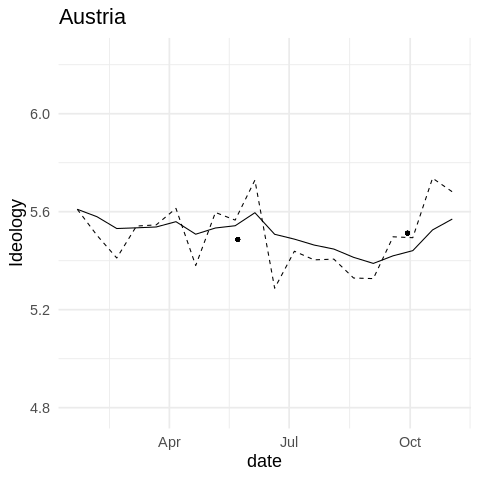

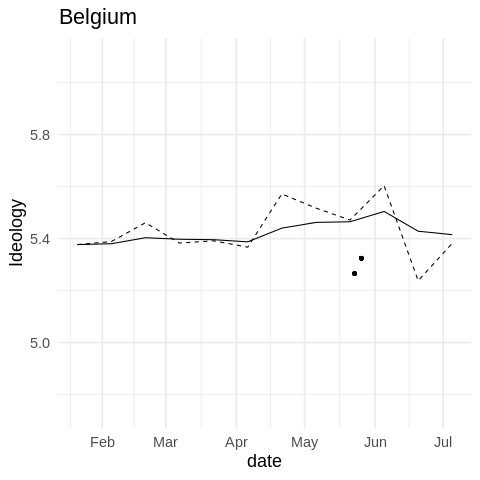

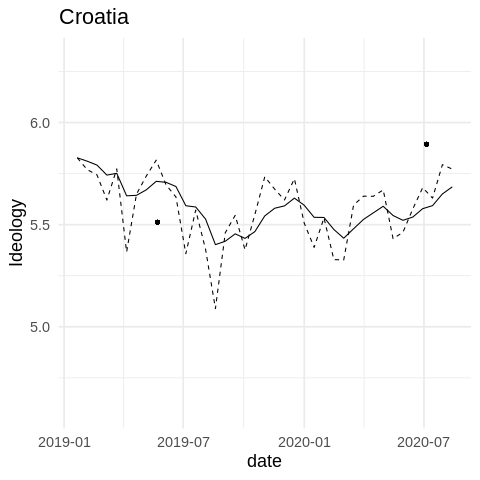

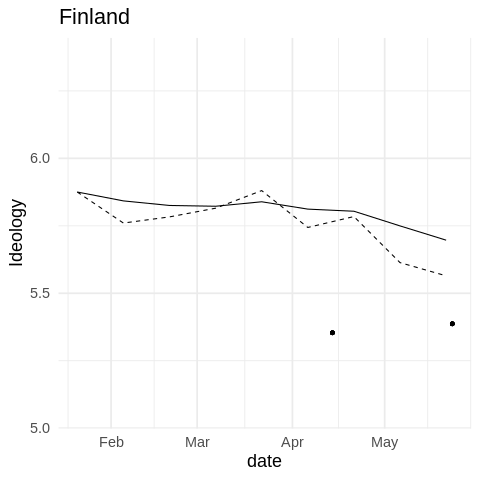

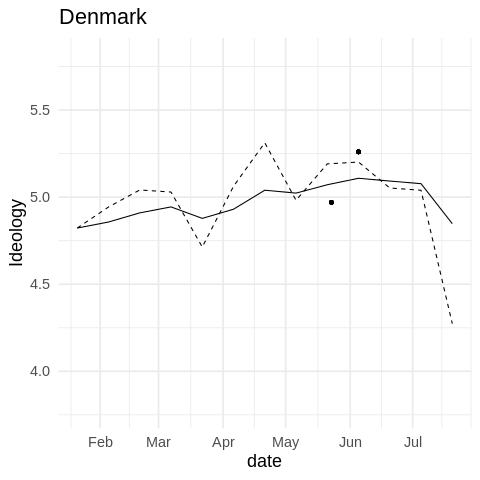

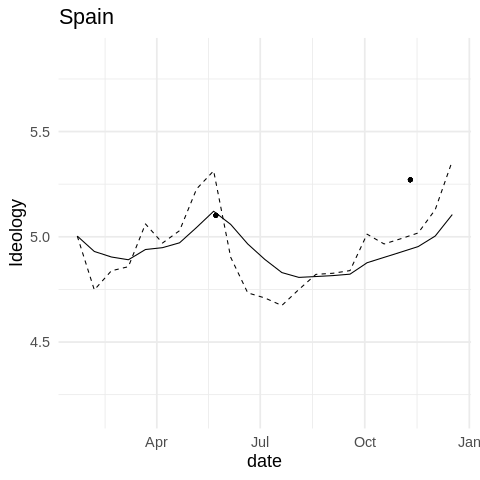

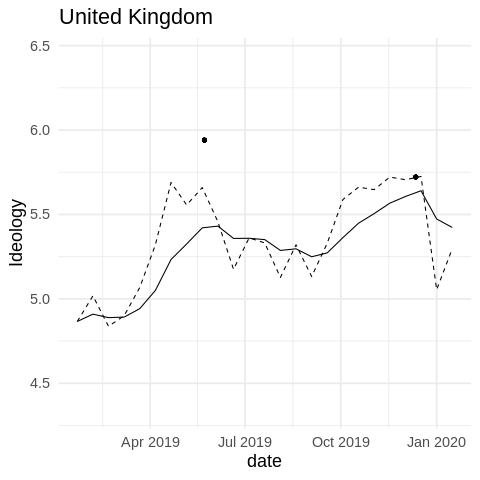

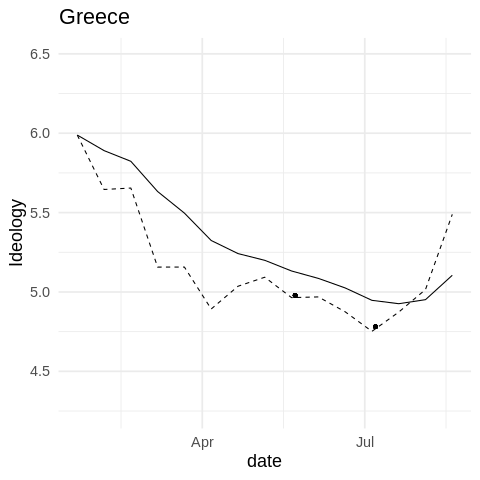

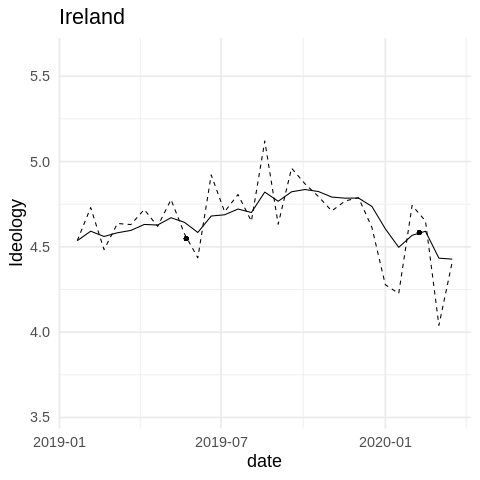

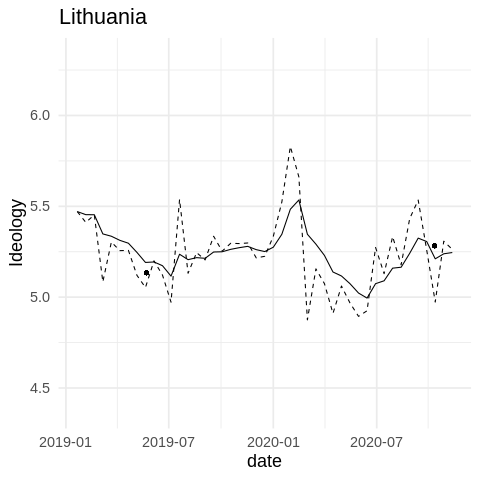

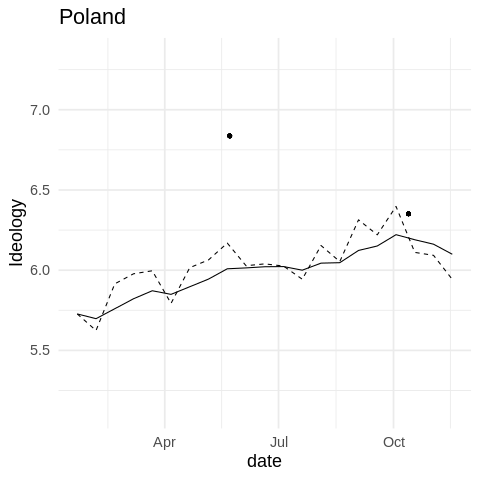

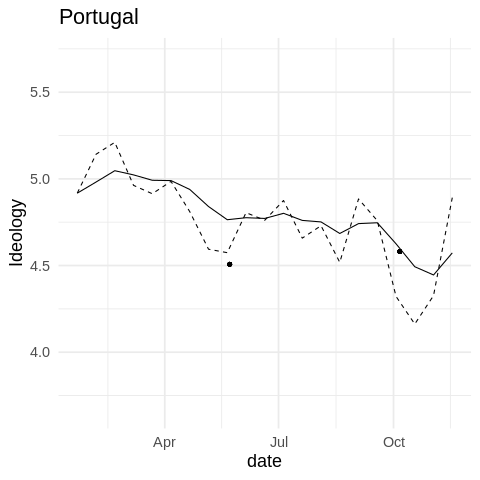

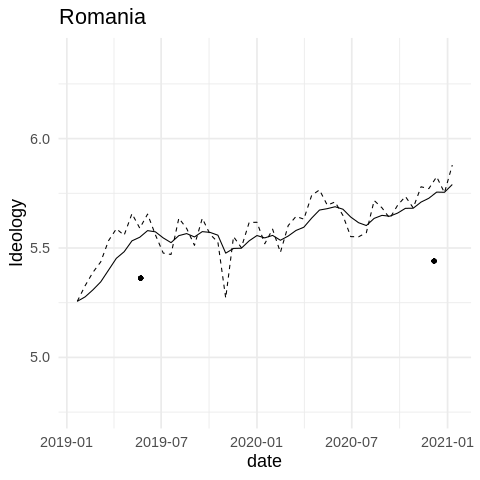

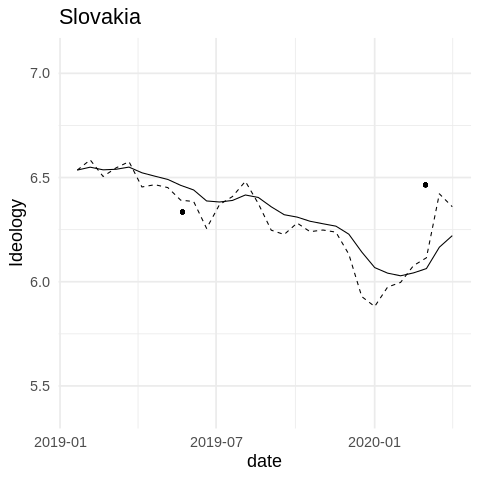

In [ ]:
%%R

countries_with_elections = c("Austria", "Belgium", "Croatia", "Finland", "Estonia", "Denmark", "Spain", "United Kingdom", "Greece", "Ireland", "Lithuania", "Poland", "Portugal", "Romania", "Slovakia" )

#countries_with_elections = c("Austria")
base_date = as.Date("2019-05-21")


m = 0.5
reload_all_data(base_date - 30 * m, base_date)
base_date = as.Date("2019-01-21")
ideo_linear_lm <- lm(formula = ideology_by_votes ~ posts + comments_mean, data=ideo_matrix)
print(summary(ideo_linear_lm))
print(sqrt(mean(ideo_linear_lm$residuals^2)))
matrix_variable <- "ideo_matrix"
base_truth_variable <- "ideology_by_votes"

model <- ideo_linear_lm

plot_list <- list()

for(coun in countries_with_elections){
      election_date = as.Date(unique((view_election %>% filter(country_name == coun) %>% filter(election_type=="parliament") %>% arrange(election_date))$election_date) %>% last())
    
    if(election_date < base_date + 30){
        next
    }
    print(coun)
    date_pointer <- base_date - 15
    
      print(paste(coun,election_date))

      country_data <- data.table(country_name=coun, date=NA, ideology=NA)
      
      while(date_pointer - 30 <= election_date){
          date_pointer <- date_pointer + 15
          print(date_pointer)

          reload_all_data(date_pointer - 30 * m, date_pointer, coun)
    
          country_prediction <- predict.lm(model, get(matrix_variable) %>% filter(country_name == coun))
    
          country_data <- country_data %>% union(data.table(country_name=coun, date=date_pointer, ideology=country_prediction))
          
          
          
      }



      country_data <- country_data %>% filter(!is.na(date))
      if(length(country_data$ideology) <= 6){
        next
      }
      country_data$ideology2 <- movavg(country_data$ideology, 6, type="e")
      parliament_election <- getParliamentElection(coun, election_date) %>% filter(!is.na(left_right)) %>% filter(!is.na(vote_share))

      if(matrix_variable=="pol_matrix"){
        country_truth <- calculate_dalton(data.table("ideology"=parliament_election$left_right, "variable"=parliament_election$vote_share))  
      }else{
        country_truth <- weighted.mean(parliament_election$left_right, parliament_election$vote_share)
      }  

      eu_truth <-  get(matrix_variable) %>% filter(country_name == coun) %>% select(base_truth_variable) 


      plot <- ggplot(country_data %>% rename(Ideology = ideology)) +
            geom_line(aes(x=date, y=Ideology), linetype = "dashed") +
            geom_line(aes(x=date, y=ideology2)) +
            geom_point(aes(x=election_date, y=country_truth)) +
            geom_point(aes(x=as.Date("2019-05-23"), y=eu_truth[[1]])) +
            ylim(min(country_data$ideology)-0.5,max(country_data$ideology, eu_truth[[1]])+0.5) +
            theme_minimal(base_size = 18) +
            ggtitle(coun)
      
      print(plot)
      ggsave(paste("ideology-", coun, ".pdf"),  plot)

}






Call:
lm(formula = dalton ~ reactions_median + posts, data = pol_matrix)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.75456 -0.20649 -0.01835  0.15495  1.36666 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.79287    0.37929   2.090   0.0469 *  
reactions_median  0.54633    0.08374   6.524 7.81e-07 ***
posts             0.21043    0.09553   2.203   0.0370 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4369 on 25 degrees of freedom
Multiple R-squared:  0.7804,	Adjusted R-squared:  0.7628 
F-statistic: 44.41 on 2 and 25 DF,  p-value: 5.907e-09

[1] 0.4128526
[1] "Austria"
[1] "Austria 2019-09-29"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-0

R[write to console]: Saving 6.67 x 6.67 in image



[1] "Belgium"
[1] "Belgium 2019-05-26"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Croatia"
[1] "Croatia 2020-07-05"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"
[1] "2020-01-01"
[1] "2020-01-16"
[1] "2020-01-31"
[1] "2020-02-15"
[1] "2020-03-01"
[1] "2020-03-16"
[1] "2020-03-31"
[1] "2020-04-15"
[1] "2020-04-30"
[1] "2020-05-15"
[1] "2020-05-30"
[1] "2020-06-14"
[1] "2020-06-29"
[1] "2020-07-14"
[1] "2020-07-29"
[1] "2020-08-13"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Finland"
[1] "Finland 2019-04-14"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Estonia"
[1] "Estonia 2019-03-03"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "Denmark"
[1] "Denmark 2019-06-05"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Spain"
[1] "Spain 2019-11-10"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "United Kingdom"
[1] "United Kingdom 2019-12-12"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"
[1] "2020-01-01"
[1] "2020-01-16"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Greece"
[1] "Greece 2019-07-07"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Ireland"
[1] "Ireland 2020-02-08"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"
[1] "2020-01-01"
[1] "2020-01-16"
[1] "2020-01-31"
[1] "2020-02-15"
[1] "2020-03-01"
[1] "2020-03-16"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Lithuania"
[1] "Lithuania 2020-10-11"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"
[1] "2020-01-01"
[1] "2020-01-16"
[1] "2020-01-31"
[1] "2020-02-15"
[1] "2020-03-01"
[1] "2020-03-16"
[1] "2020-03-31"
[1] "2020-04-15"
[1] "2020-04-30"
[1] "2020-05-15"
[1] "2020-05-30"
[1] "2020-06-14"
[1] "2020-06-29"
[1] "2020-07-14"
[1] "2020-07-29"
[1] "2020-08-13"
[1] "2020-08-28"
[1] "2020-09-12"
[1] "2020-09-27"
[1] "2020-10-12"
[1] "2020-10-27"
[1] "2020-11-11"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Poland"
[1] "Poland 2019-10-13"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Portugal"
[1] "Portugal 2019-10-06"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Romania"
[1] "Romania 2020-12-06"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"
[1] "2020-01-01"
[1] "2020-01-16"
[1] "2020-01-31"
[1] "2020-02-15"
[1] "2020-03-01"
[1] "2020-03-16"
[1] "2020-03-31"
[1] "2020-04-15"
[1] "2020-04-30"
[1] "2020-05-15"
[1] "2020-05-30"
[1] "2020-06-14"
[1] "2020-06-29"
[1] "2020-07-14"
[1] "2020-07-29"
[1] "2020-08-13"
[1] "2020-08-28"
[1] "2020-09-12"
[1] "2020-09-27"
[1] "2020-10-12"
[1] "2020-10-27"
[1] "2020-11-11"
[1] "2020-11-26"
[1] "2020-12-11"
[1] "2020-12-26"
[1] "2021-01-10"


R[write to console]: Saving 6.67 x 6.67 in image



[1] "Slovakia"
[1] "Slovakia 2020-02-29"
[1] "2019-01-21"
[1] "2019-02-05"
[1] "2019-02-20"
[1] "2019-03-07"
[1] "2019-03-22"
[1] "2019-04-06"
[1] "2019-04-21"
[1] "2019-05-06"
[1] "2019-05-21"
[1] "2019-06-05"
[1] "2019-06-20"
[1] "2019-07-05"
[1] "2019-07-20"
[1] "2019-08-04"
[1] "2019-08-19"
[1] "2019-09-03"
[1] "2019-09-18"
[1] "2019-10-03"
[1] "2019-10-18"
[1] "2019-11-02"
[1] "2019-11-17"
[1] "2019-12-02"
[1] "2019-12-17"
[1] "2020-01-01"
[1] "2020-01-16"
[1] "2020-01-31"
[1] "2020-02-15"
[1] "2020-03-01"
[1] "2020-03-16"
[1] "2020-03-31"


R[write to console]: Saving 6.67 x 6.67 in image



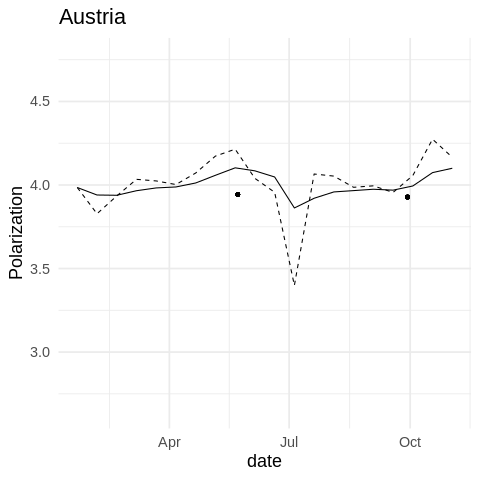

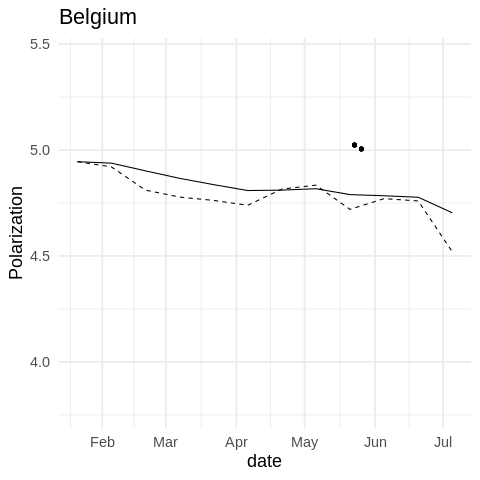

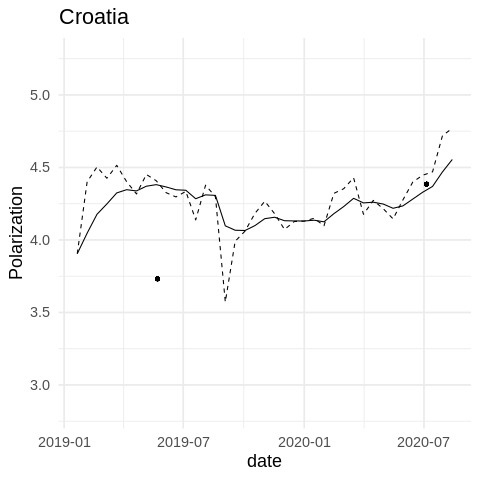

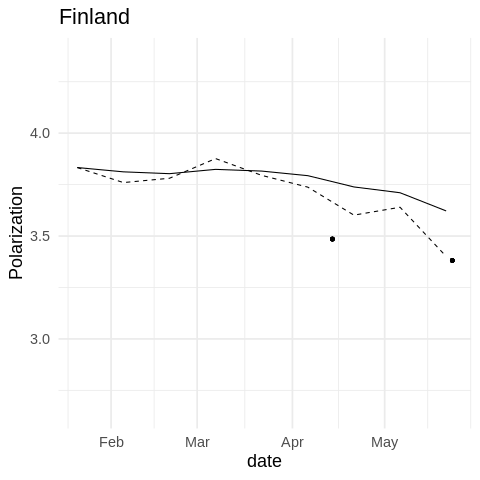

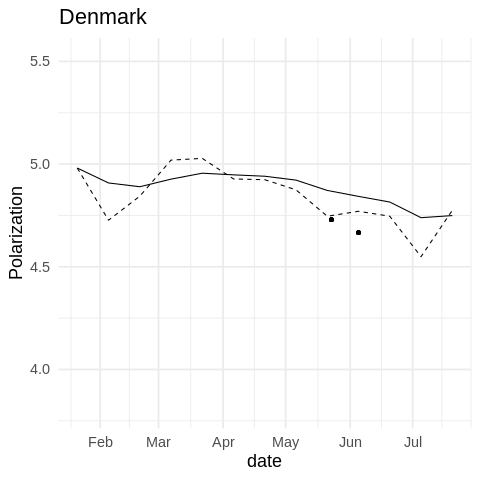

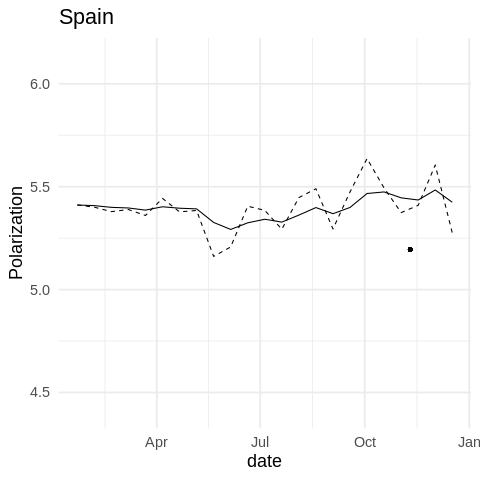

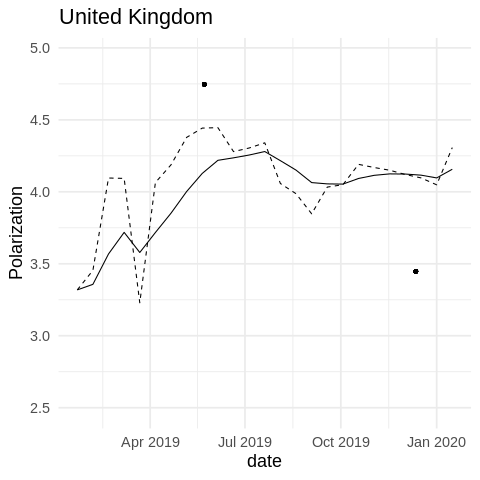

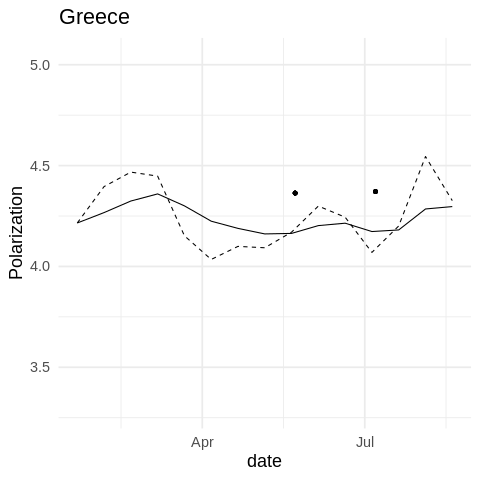

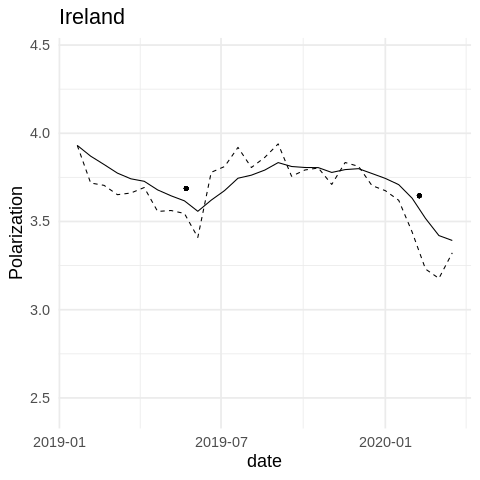

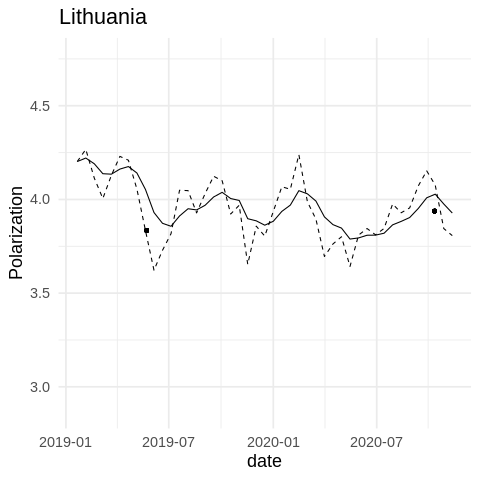

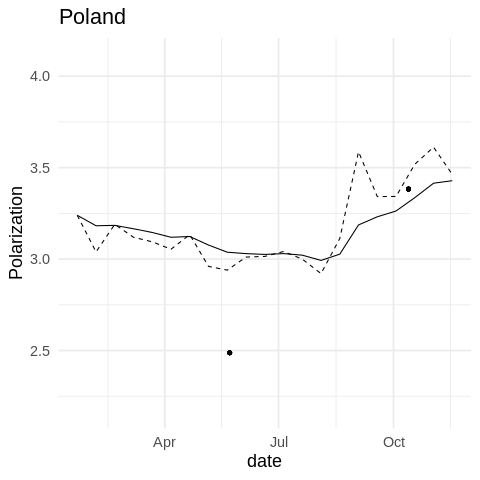

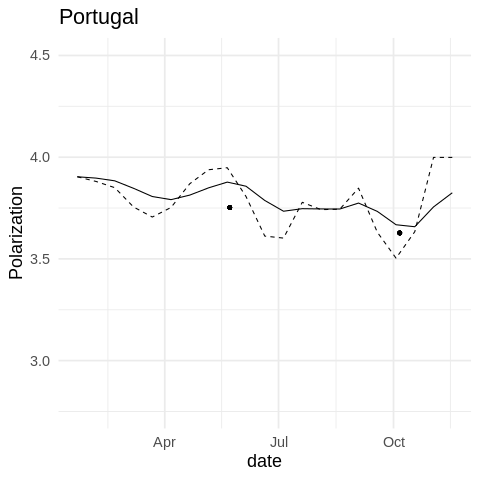

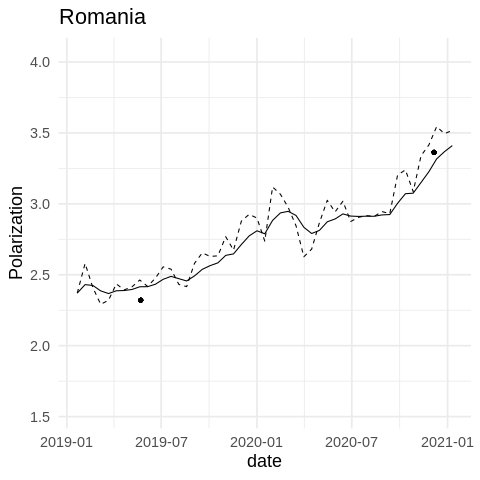

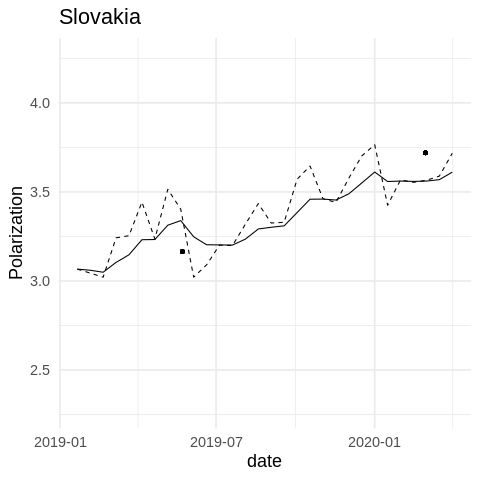

In [ ]:
%%R

countries_with_elections = c("Austria", "Belgium", "Croatia", "Finland", "Estonia", "Denmark", "Spain", "United Kingdom", "Greece", "Ireland", "Lithuania", "Poland", "Portugal", "Romania", "Slovakia" )

#countries_with_elections = c("Spain")
base_date = as.Date("2019-05-21")


m = 0.75
reload_all_data(base_date - 30 * m, base_date)
dalton_linear_lm <- lm(formula = dalton ~ reactions_median + posts, data=pol_matrix)
base_date = as.Date("2019-01-21")
print(summary(dalton_linear_lm))
print(sqrt(mean(dalton_linear_lm$residuals^2)))
matrix_variable <- "pol_matrix"
base_truth_variable <- "dalton"

model <- dalton_linear_lm

for(coun in countries_with_elections){
      election_date = as.Date(unique((view_election %>% filter(country_name == coun) %>% filter(election_type=="parliament") %>% arrange(election_date))$election_date) %>% last())
    
    if(election_date < base_date + 30){
        next
    }
    print(coun)
    date_pointer <- base_date - 15
    
      print(paste(coun,election_date))

      country_data <- data.table(country_name=coun, date=NA, polarization=NA)
      
      while(date_pointer - 30 <= election_date){
          date_pointer <- date_pointer + 15
          print(date_pointer)

          reload_all_data(date_pointer - 30 * m, date_pointer, coun)
    
          country_prediction <- predict.lm(model, get(matrix_variable) %>% filter(country_name == coun))
    
          country_data <- country_data %>% union(data.table(country_name=coun, date=date_pointer, polarization=country_prediction))
          
          
          
      }



      country_data <- country_data %>% filter(!is.na(date))
      parliament_election <- getParliamentElection(coun, election_date) %>% filter(!is.na(left_right)) %>% filter(!is.na(vote_share))
      if(length(country_data$polarization) <= 7){
        next
      }
      country_data$polarization2 <- movavg(country_data$polarization, 6, type="e")

      if(matrix_variable=="pol_matrix"){
        country_truth <- calculate_dalton(data.table("ideology"=parliament_election$left_right, "variable"=parliament_election$vote_share))  
      }else{
        country_truth <- weighted.mean(parliament_election$left_right, parliament_election$vote_share)
      }  

      eu_truth <-  get(matrix_variable) %>% filter(country_name == coun) %>% select(base_truth_variable) 

      plot <- ggplot(country_data %>% rename(Polarization = polarization)) +
            geom_line(aes(x=date, y=Polarization), linetype = "dashed") +
            geom_line(aes(x=date, y=polarization2)) +
            geom_point(aes(x=election_date, y=country_truth)) +
            geom_point(aes(x=as.Date("2019-05-23"), y=eu_truth[[1]])) +
            ylim(min(country_data$polarization)-0.75,max(country_data$polarization)+0.5) +
            theme_minimal(base_size = 18) +
            ggtitle(coun)

      print(plot)
      
    ggsave(paste("polarization", coun, ".pdf"),  plot)

}





# Delete ideology and polarization generated

In [ ]:
from os import listdir
from zipfile import ZipFile
import re, os
files = listdir()
zipObj = ZipFile('ideologies.zip', 'w')

for file in files:
  if re.match(r"ideo*", file) or re.match(r"pol*", file):
    print(file)
    zipObj.write(file) #os.remove(file)


zipObj.close()

ideo_2019-05-21_2019-06-05_Croatia.csv
pol_2019-06-27_2019-07-20_United Kingdom.csv
ideo_2019-08-04_2019-08-19_Lithuania.csv
pol_2019-01-13_2019-02-05_Belgium.csv
ideo_2019-01-06_2019-01-21_Estonia.csv
pol_2019-08-04_2019-08-19_Lithuania.csv
ideo_2020-10-12_2020-10-27_Lithuania.csv
ideo_2020-01-16_2020-01-31_Lithuania.csv
pol_2019-07-05_2019-07-20_Ireland.csv
ideo_2019-07-12_2019-08-04_Romania.csv
ideo_2019-01-21_2019-02-05_Lithuania.csv
pol_2019-05-21_2019-06-05_Denmark.csv
pol_2019-04-13_2019-05-06_Ireland.csv
ideo_2019-04-06_2019-05-21_none.csv
ideo_2020-04-15_2020-04-30_Romania.csv
ideo_2019-03-14_2019-04-06_Poland.csv
pol_2020-02-07_2020-03-01_Romania.csv
ideo_2020-07-29_2020-08-13_Croatia.csv
ideo_2020-01-01_2020-01-16_United Kingdom.csv
pol_2019-02-27_2019-03-22_Estonia.csv
pol_2020-11-19_2020-12-04_Romania.csv
ideo_2019-03-22_2019-04-06_United Kingdom.csv
pol_2019-05-28_2019-06-20_Spain.csv
ideo_2020-01-16_2020-01-31_Croatia.csv
pol_2020-05-30_2020-06-14_Romania.csv
ideo_2019-0

In [ ]:
from os import listdir
from zipfile import ZipFile
import re, os
files = listdir()
zipObj = ZipFile('pdf_images.zip', 'w')

for file in files:
  if re.match(r".*pdf", file):
    print(file)
    zipObj.write(file)


zipObj.close()

polarization Slovakia .pdf
Figure3.pdf
ideology- Croatia .pdf
ideology- Spain .pdf
polarization Belgium .pdf
polarization Finland .pdf
ideology- United Kingdom .pdf
polarization Greece .pdf
polarization Portugal .pdf
ideology- Austria .pdf
ideology- Poland .pdf
polarization Spain .pdf
ideology- Greece .pdf
ideology- Lithuania .pdf
ideology- Belgium .pdf
polarization Poland .pdf
polarization Lithuania .pdf
ideology- Slovakia .pdf
ideology- Portugal .pdf
Figure5.pdf
ideology- Ireland .pdf
polarization Romania .pdf
ideology- Romania .pdf
Figure2.pdf
polarization Ireland .pdf
Figure4.pdf
polarization United Kingdom .pdf
polarization Austria .pdf
ideology- Finland .pdf
ideology- Denmark .pdf
polarization Denmark .pdf
polarization Croatia .pdf


In [ ]:
import zipfile
with zipfile.ZipFile("ideologies.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
from os import listdir
from zipfile import ZipFile
import re, os
files = listdir()


for file in files:
  if re.match(r"ideo*", file) or re.match(r"pol*", file):
    print(file)
    os.remove(file)




ideo_2019-04-06_2019-05-21_none.csv
pol_2020-11-19_2020-12-04_Romania.csv
pol_2020-06-18_2020-07-03_Croatia.csv
ideo_2019-09-11_2019-10-04_Portugal.csv
pol_2019-05-19_2019-06-03_Denmark.csv
pol_2019-09-18_2019-10-11_Poland.csv
ideo_2019-10-24_2019-11-08_Spain.csv
ideo_2019-04-21_2019-05-21_none.csv
pol_2020-02-04_2020-02-27_Slovakia.csv
pol_2019-06-20_2019-07-05_Greece.csv
ideo_2019-09-19_2019-10-04_Portugal.csv
pol_2019-10-24_2019-11-08_Spain.csv
pol_2020-01-14_2020-02-06_Ireland.csv
ideo_2019-02-14_2019-03-01_Estonia.csv
ideo_2019-04-28_2019-05-21_none.csv
pol_2019-05-09_2019-05-24_Belgium.csv
ideo_2018-12-31_2022-01-01_none.csv
ideo_2020-02-04_2020-02-27_Slovakia.csv
ideo_2020-02-12_2020-02-27_Slovakia.csv
pol_2019-04-06_2019-05-21_none.csv
pol_2019-05-01_2019-05-24_Belgium.csv
ideo_2020-09-24_2020-10-09_Lithuania.csv
pol_2019-04-21_2019-05-21_none.csv
pol_2019-11-17_2019-12-10_United Kingdom.csv
pol_2019-11-25_2019-12-10_United Kingdom.csv
ideo_2020-06-10_2020-07-03_Croatia.csv
pol